Name: Ryan Young

Date: 2024-05-15

# Molecular Scent Analysis
Hi!

Welcome to this exploratory analysis notebook where we aim to predict whether a molecule might smell like a flower.

This notebook's goal is to demonstrate an approach to solving a problem related to molecular scent prediction, with a focus on exploratory data analysis, model evaluation, and visualization of results.

Towards the end, we will also explore some problems related to message passing and graph neural networks.

# Dependencies
The following cell clones a private GitHub repo called `gin`
 -- where I developed the code for this analysis.

Even with notebooks, I tend to modularize pieces into repos for
- reproducibility
- CI/CD
- testing

The "fine-grained" `access_token` token below grants permission to pull the private repo.

In [1]:
import importlib
import os
import shutil

# Check if the `gin` package is installed
module_spec = importlib.util.find_spec('gin')
module_spec

# Check if the `gin` package is installed, if refresh is True, then we will refresh the package
refresh = False
if module_spec and refresh:
    shutil.rmtree(folder)
    gin_path = os.path.dirname(module_spec.origin)
    # NOTE: This is an access token fenced-off for this specific private repository - only usable to clone this single private repo.
    repo_url = f'https://github.com/synapticsage/gin.git'
    os.system(f'git clone {repo_url}')
    os.chdir('gin')
    # !pip install . 
    # pip install the package
    # os.chdir('..')

In [12]:
os.chdir(os.path.dirname(os.path.dirname(module_spec.origin)))
os.getcwd()

'/Users/ryoung/Code/repos/SMELL/DREAM'

In [13]:
%matplotlib inline

import gin

import numpy as np
import torch
from sklearn import ensemble as sklearn_ensemble
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
# import seaborn as sns
plt.rcParams['figure.dpi'] = 150

# Dataset

Here we will use data managed by [the Pyrfume project](https://pyrfume.org/) 

The [SMILES strings](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) representing the molecular structures and their corresponding binary labels are provided.

In [14]:
data_df = gin.data.pyrfume.read_local_csv()

In [15]:
data_df

,floral
IsomericSMILES,
CC(C)CC(C)(O)C1CCCS1,0
CCCCCCCCC(=O)C(=O)OC(=C(C)C)C(O)CO,0
CCCCC=COC(=O)C=CCCCCC,0
CCCC(CCOC)[SH]=C(O)OCC,0
CCCCCCCCC(S)C=O,0
...,...
CCC1CSSSC1(CC)CC,0
CC(S)SS,0
CCC(C)C(=S)OCC(C)C,0



Now that we have the data loaded, what should we learn about this dataset?

In [16]:
data_df['floral'].isnull().sum()

0


No missing values - reassuring!

Let's see the distribution of the labels in the dataset.

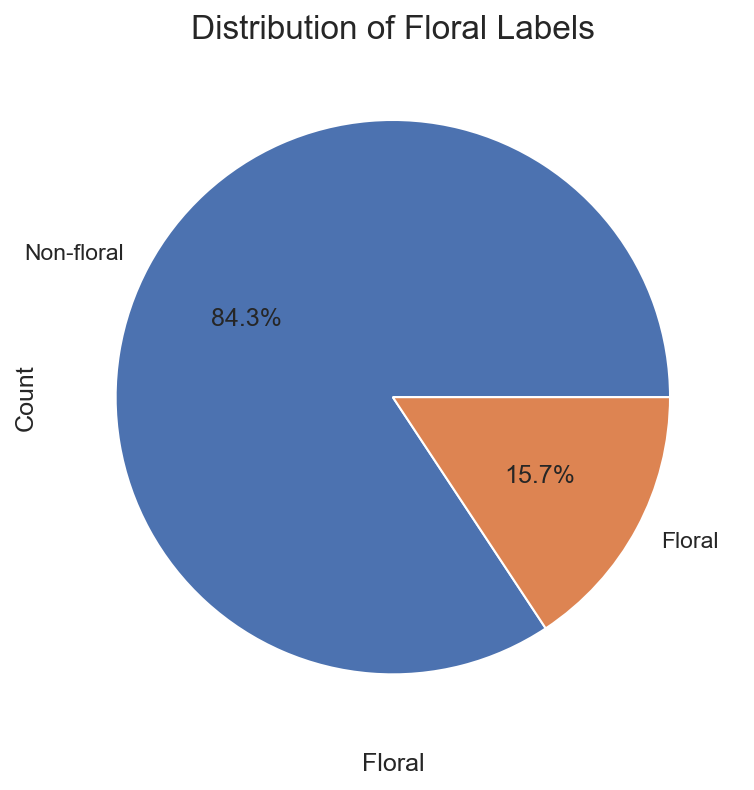

In [17]:
gin.explore.pyrfume.plot_floral_distribution(data_df, kind='pie')

👆 The large majority of the dataset is non-floral ❌💐. We should consider **class imbalance** downstream.

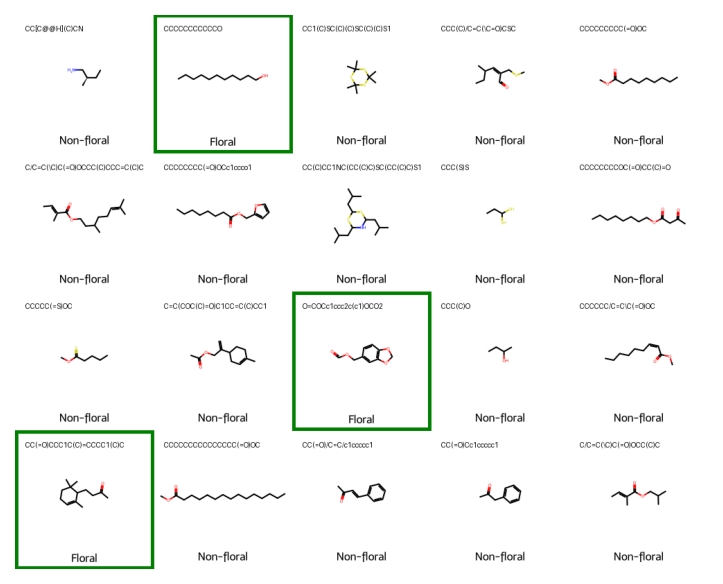

In [18]:
# Let's visualize some of the molecular structures in the dataset and see if we can spot any patterns.
gin.explore.pyrfume.plot_molecular_structures_w_label(data_df, num_samples=20)

And let's examine a few more samples.

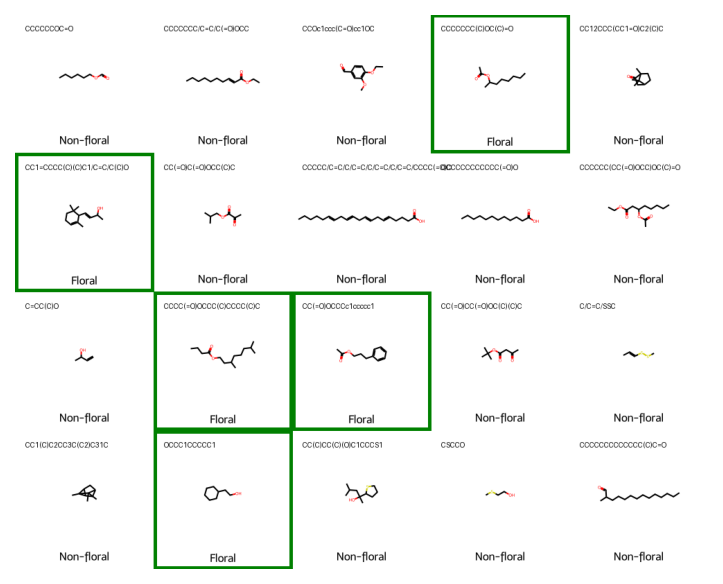

In [19]:
gin.explore.pyrfume.plot_molecular_structures_w_label(data_df, num_samples=20)

## Hypotheses

Some things of note just from the visualization (hypotheses / possibillium / wild guesses):

- The 🪻 floral molecules nearly all have oxygen with free electron pair. Doubled-bond oxygen alone  seems less often associated with floral molecules.
- Nitrogen-containing rarely floral - though, devil's advocate, I also see fewer nitrogen-containing molecules to form an opinion.

# Molecule Featurization

In the next step, we will try to "digitize" each molecule by creating a 1D numpy array based on its molecular structure. Can you create a molecular fingerprint with `rdkit` ([documentation](https://www.rdkit.org/docs/GettingStartedInPython.html#fingerprinting-and-molecular-similarity))?

In [20]:
def featurize_smiles(smiles_str: str,
                     method: str = 'combined') -> np.ndarray:
  """Convert a molecule SMILES into a 1D feature vector."""
  if method == 'morgan':
    fingerprint = gin.features.get_morgan_fingerprint(smiles_str)
  elif method == 'maccs':
    fingerprint = gin.features.get_maccs_keys_fingerprint(smiles_str)
  elif method == 'combined':
    fingerprint = gin.features.get_combined_fingerprint(smiles_str)
  else:
    raise ValueError(f"Invalid method: {method}")
  return fingerprint

featurize_smiles('CC(C)CC(C)(O)C1CCCS1')

array([0, 1, 0, ..., 0, 0, 0])

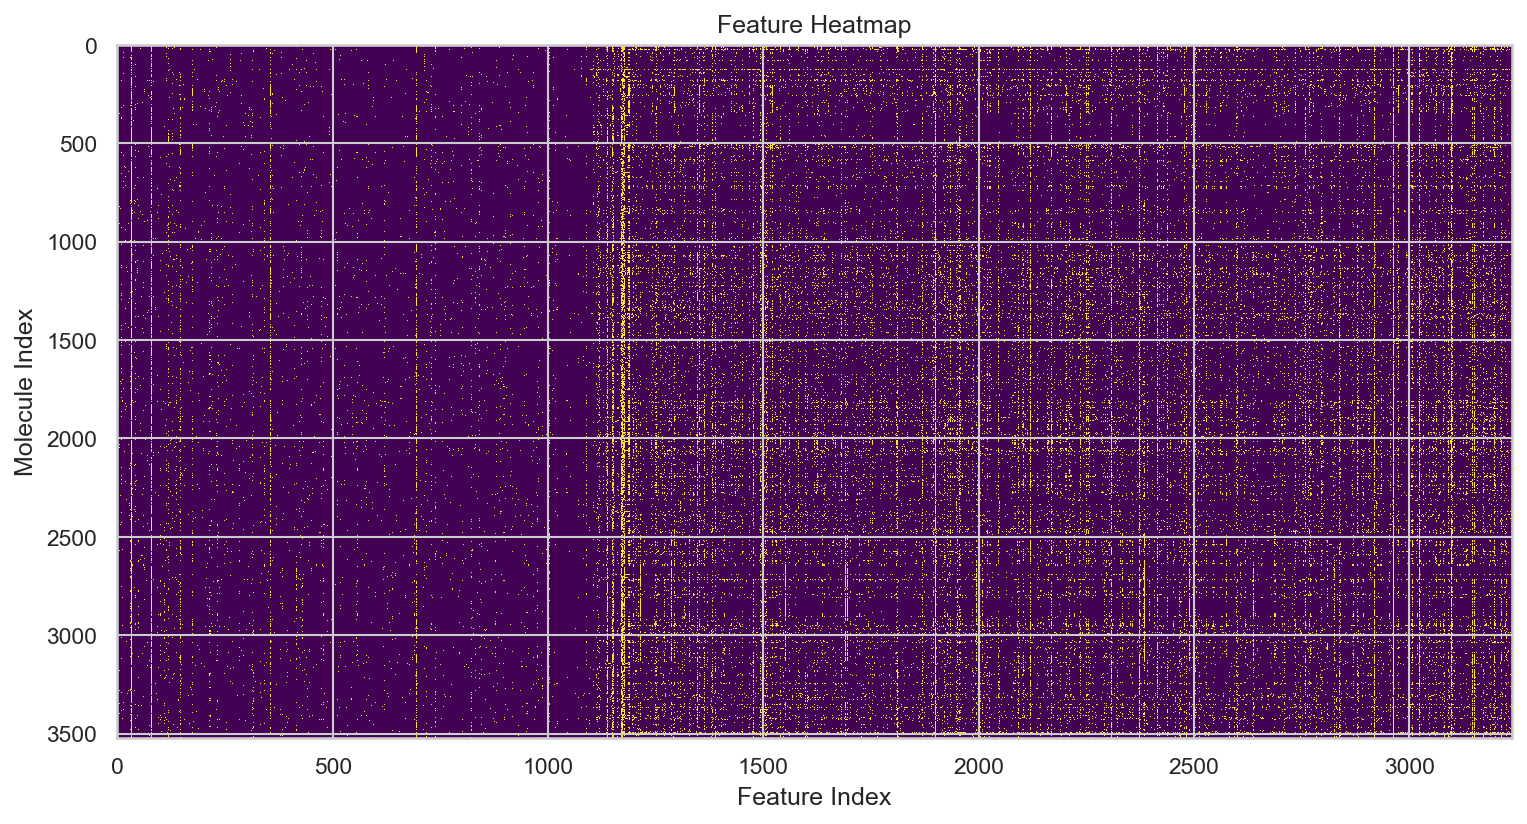

In [21]:
# Construct the features `x` and labels `y` for the model
x = np.array([featurize_smiles(v) for v in data_df.index])
from sklearn.preprocessing import OrdinalEncoder
label_encoder = OrdinalEncoder()
x = label_encoder.fit_transform(x)
y = data_df['floral'].values
gin.explore.pyrfume.plot_feature_heatmap(x)

Having noticed the above, we should maybe be thinking about the following

- Feature scaling - less necessary for tree-based models
- High class cardinality - hopefully not an issue
- Feature imbalance - this is a possible issue, but we can address this
  - SMOTE is an option for increasing the minority class

## Splitting the data, cross-validation
we have to split the data into training and testing sets.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

smote = SMOTE()
# Resampling before splitting the data can lead to data leakage
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
X_test_res, y_test_res = smote.fit_resample(X_test, y_test)

## Train and evaluate a random forest (RF) model

We will use the RF implementation from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [23]:
# What hyper-parameter should we use?
best_params = {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}

model = sklearn_ensemble.RandomForestClassifier(**best_params)
model_res = sklearn_ensemble.RandomForestClassifier(**best_params)

# How do we fit and inference with the model?
rf_y_pred = model.fit(X_train, y_train).predict(X_test)
rf_y_pred_res = model_res.fit(X_train_res, y_train_res).predict(X_test_res)
rf_y_pred_res2uns = model_res.predict(X_test)

And out of curiosity, let's also try an ensemble - even though for production-level models, this is likely overkill. A tiny performance boost often isn't worth the time and complexity.

## Scoring / Evaluation 📝

How do we evaluate the model performance? What metrics are relevant here?

This is binary classification - we care about precision, recall, F1, and AUC-ROC.

----------------
Random Forest
----------------
Accuracy: 0.8680851063829788
Precision: 0.6172839506172839
Recall: 0.44642857142857145
F1 Score: 0.5181347150259067
F1 Score0: 0.923582580115037
AUC-ROC Score: N/A


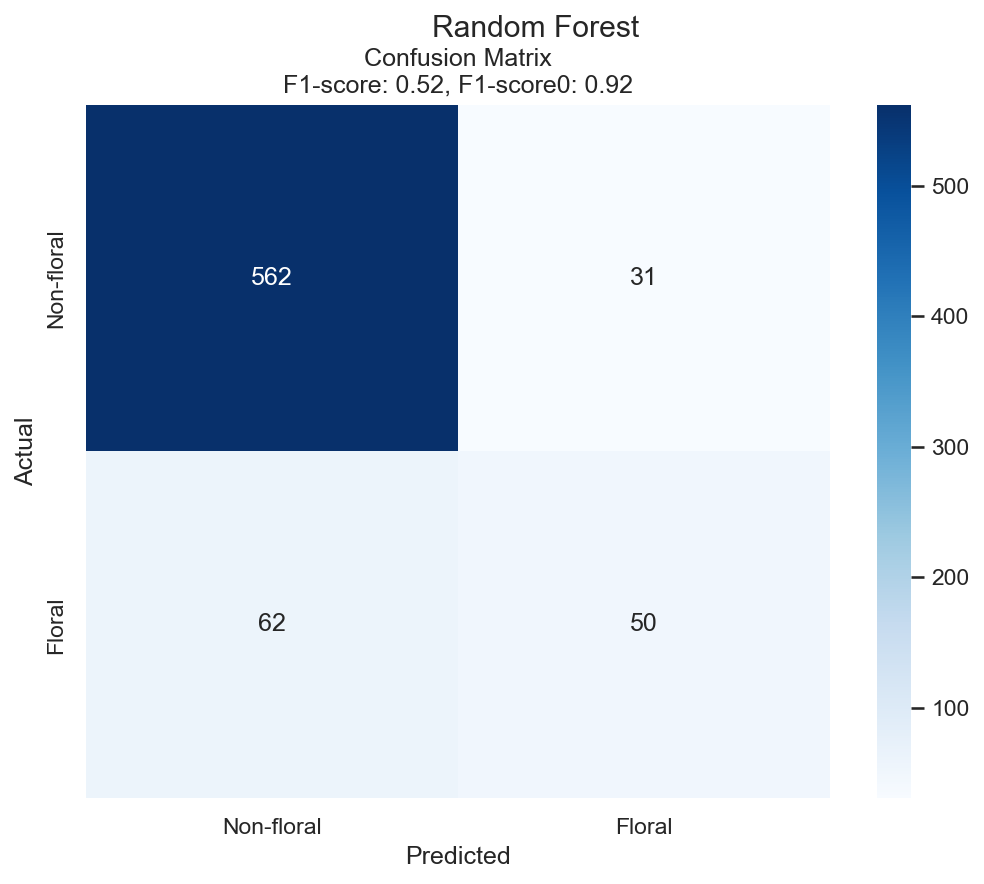

In [24]:
# What sort of visualization is needed here?
print("----------------")
print("Random Forest")
print("----------------")
suptitle = 'Random Forest'
gin.validate.evaluate_model(y_test, rf_y_pred)
gin.validate.plot_confusion_matrix(y_test, rf_y_pred, suptitle=suptitle)

----------------
Random Forest - Resampled
----------------
Accuracy: 0.8765957446808511
Precision: 0.6344086021505376
Recall: 0.5267857142857143
F1 Score: 0.5756097560975609
F1 Score0: 0.9278008298755187
AUC-ROC Score: N/A


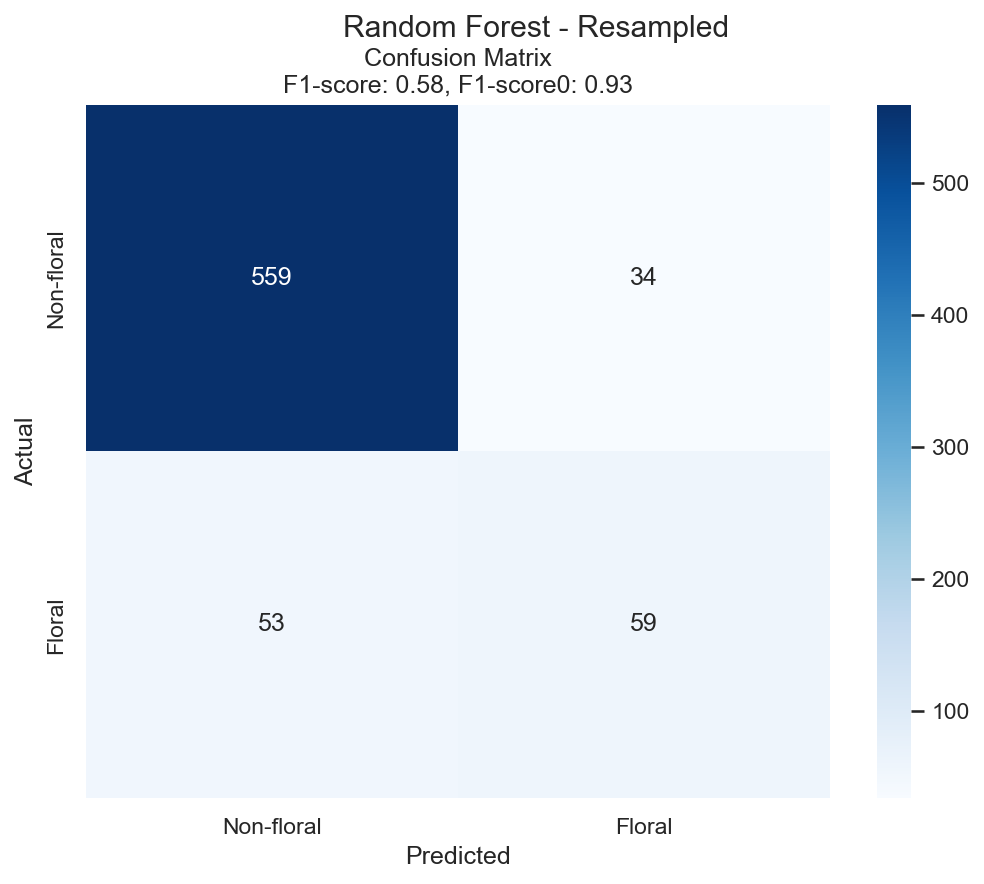

In [25]:
print("----------------")
print("Random Forest - Resampled")
print("----------------")
suptitle = 'Random Forest - Resampled'
gin.validate.evaluate_model(y_test, rf_y_pred_res2uns)
gin.validate.plot_confusion_matrix(y_test, rf_y_pred_res2uns, suptitle=suptitle)

In [26]:
start_time = time.time()
from sklearn.linear_model import LogisticRegression
clf1 = LogisticRegression(max_iter=1000)
clf2 = sklearn_ensemble.RandomForestClassifier(**best_params)
clf3 = sklearn_ensemble.GradientBoostingClassifier()

# VotingClassifier with hard voting
model_vote = sklearn_ensemble.VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gb', clf3)], voting='hard')
model_vote_res = sklearn_ensemble.VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gb', clf3)], voting='hard')

# Fit and predict
print("Fitting vote model")
model_vote.fit(X_train, y_train)
eclf_y_pred = model_vote.predict(X_test)

print("Fitting the res vote model")
model_vote_res.fit(X_train_res, y_train_res)
eclf_y_pred_res = model_vote_res.predict(X_test_res)
eclf_y_pred_res2uns = model_vote_res.predict(X_test)

print("Time taken: ", time.time() - start_time)

Fitting vote model
Fitting the res vote model
Time taken:  50.45603108406067


----------------
Ensemble
----------------
Accuracy: 0.8723404255319149
Precision: 0.6486486486486487
Recall: 0.42857142857142855
F1 Score: 0.5161290322580645
F1 Score0: 0.9264705882352942
AUC-ROC Score: N/A


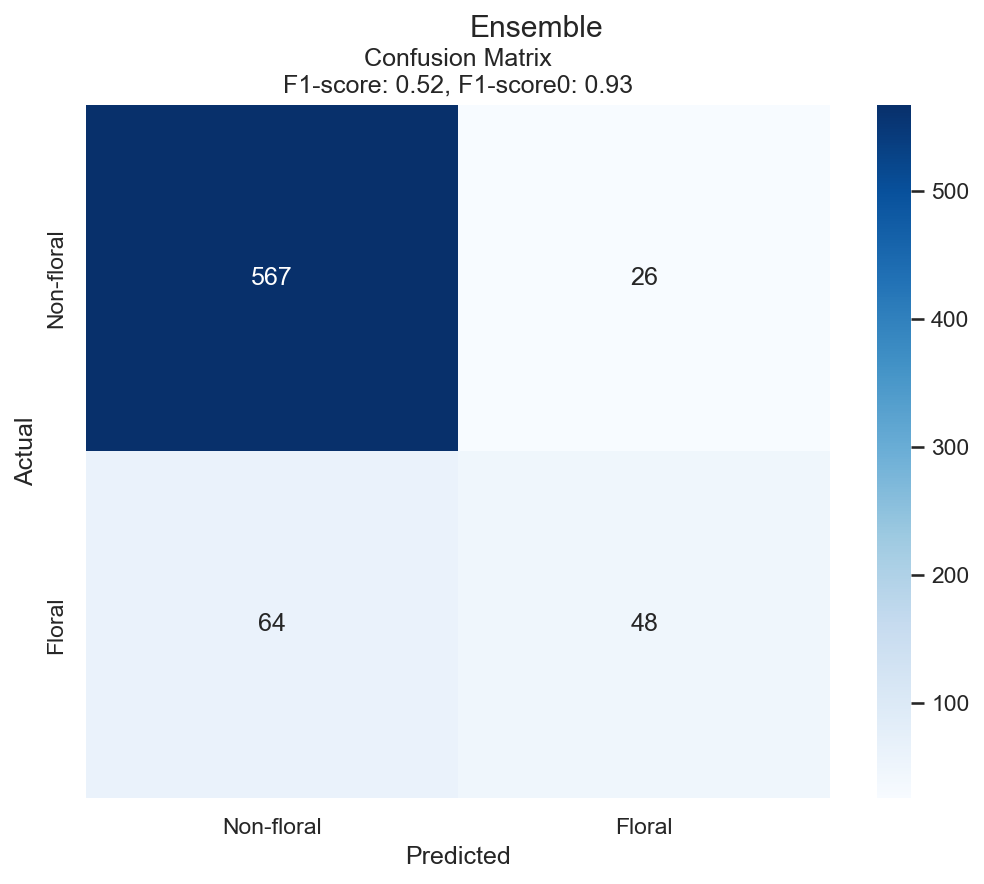

In [27]:
print("----------------")
print("Ensemble")
print("----------------")
suptitle = "Ensemble"
gin.validate.evaluate_model(y_test, eclf_y_pred)
gin.validate.plot_confusion_matrix(y_test, eclf_y_pred, suptitle=suptitle)

----------------
Ensemble - Resampled
----------------
Accuracy: 0.8666666666666667
Precision: 0.5803571428571429
Recall: 0.5803571428571429
F1 Score: 0.5803571428571429
F1 Score0: 0.9207419898819561
AUC-ROC Score: N/A


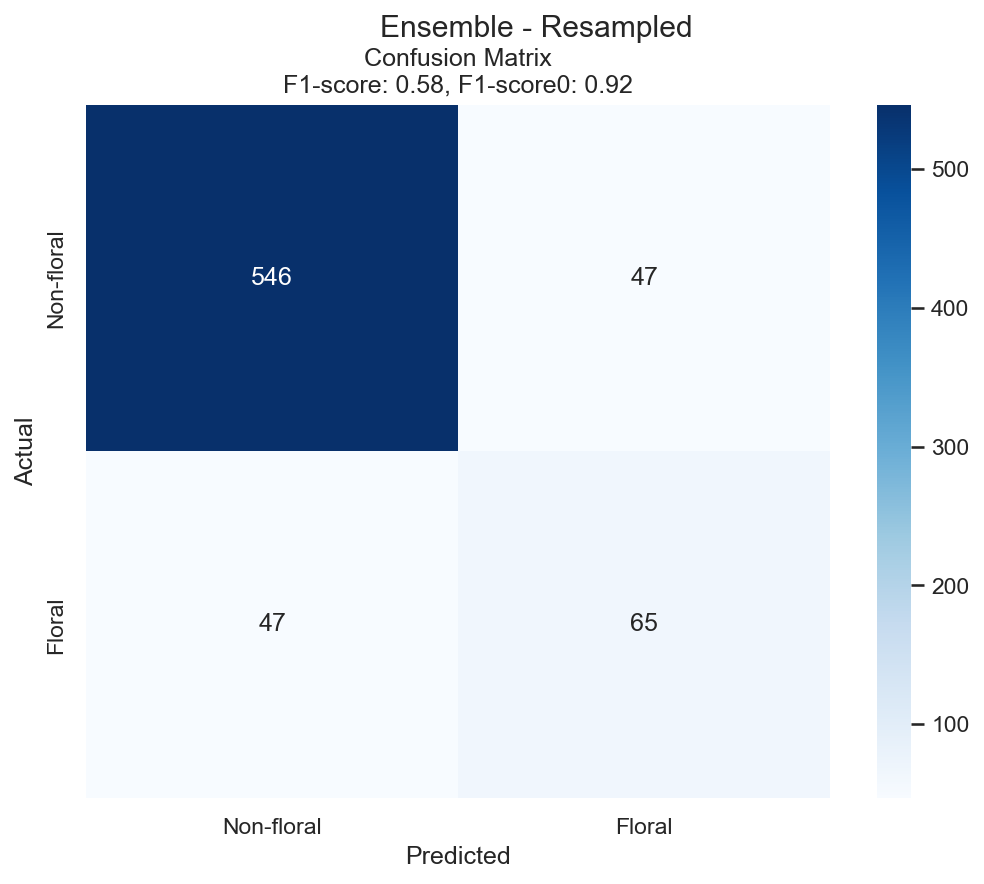

In [28]:
print("----------------")
print("Ensemble - Resampled")
print("----------------")
suptitle = "Ensemble - Resampled"
gin.validate.evaluate_model(y_test, eclf_y_pred_res2uns)
gin.validate.plot_confusion_matrix(y_test, eclf_y_pred_res2uns, suptitle=suptitle)

By default random forest sets a default, but perhaps that's not ideal. We have a great deal of choice for type I type II error, and situationally these change.

So let's examine how everything changes as a function of threshold.

> Note: for hyperparameter tuning, usually we want a train, test, and validation set. But since it already works well above with SMOTE, I'm going to forgo a validation set for this exercise 😈.

/Users/ryoung/Code/repos/SMELL/DREAM/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryoung/Code/repos/SMELL/DREAM/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryoung/Code/repos/SMELL/DREAM/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

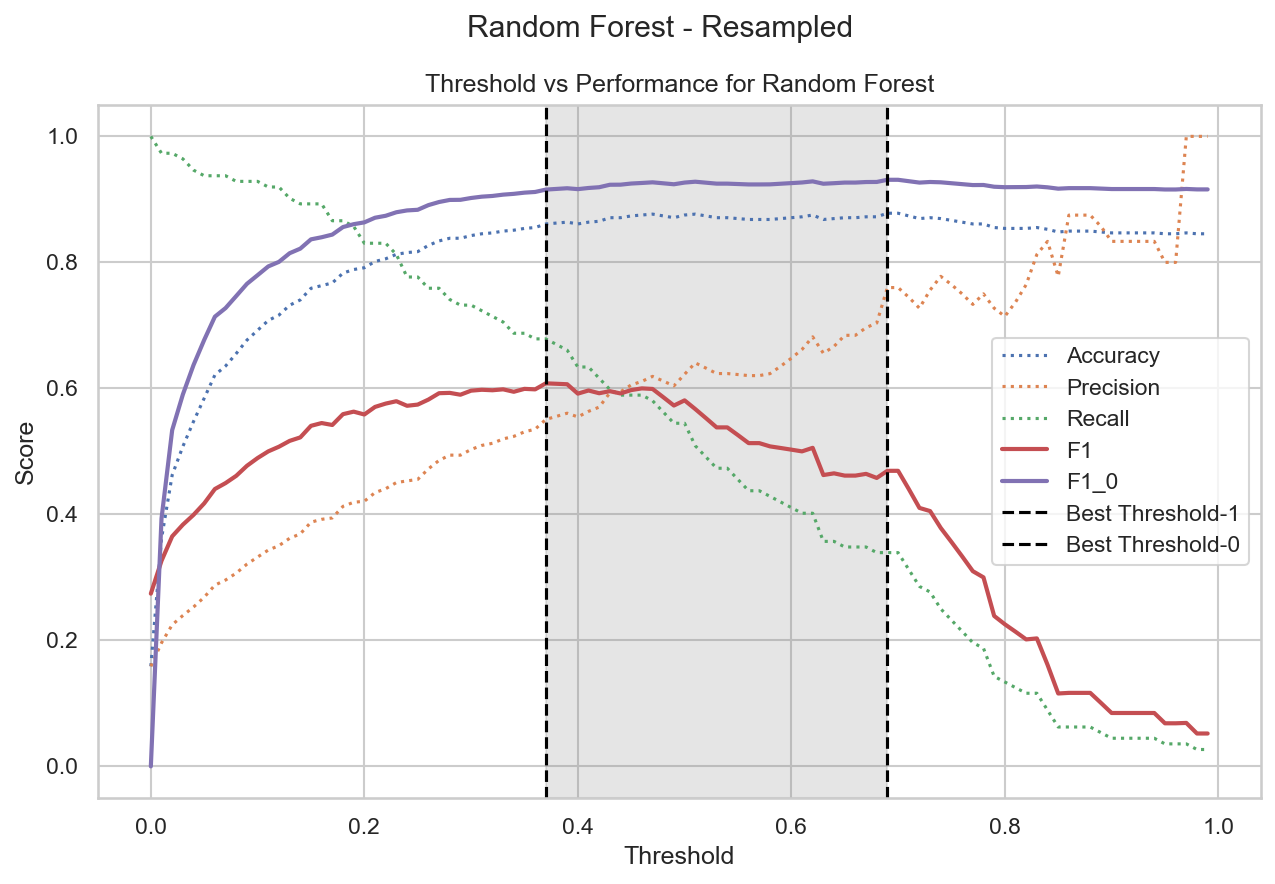

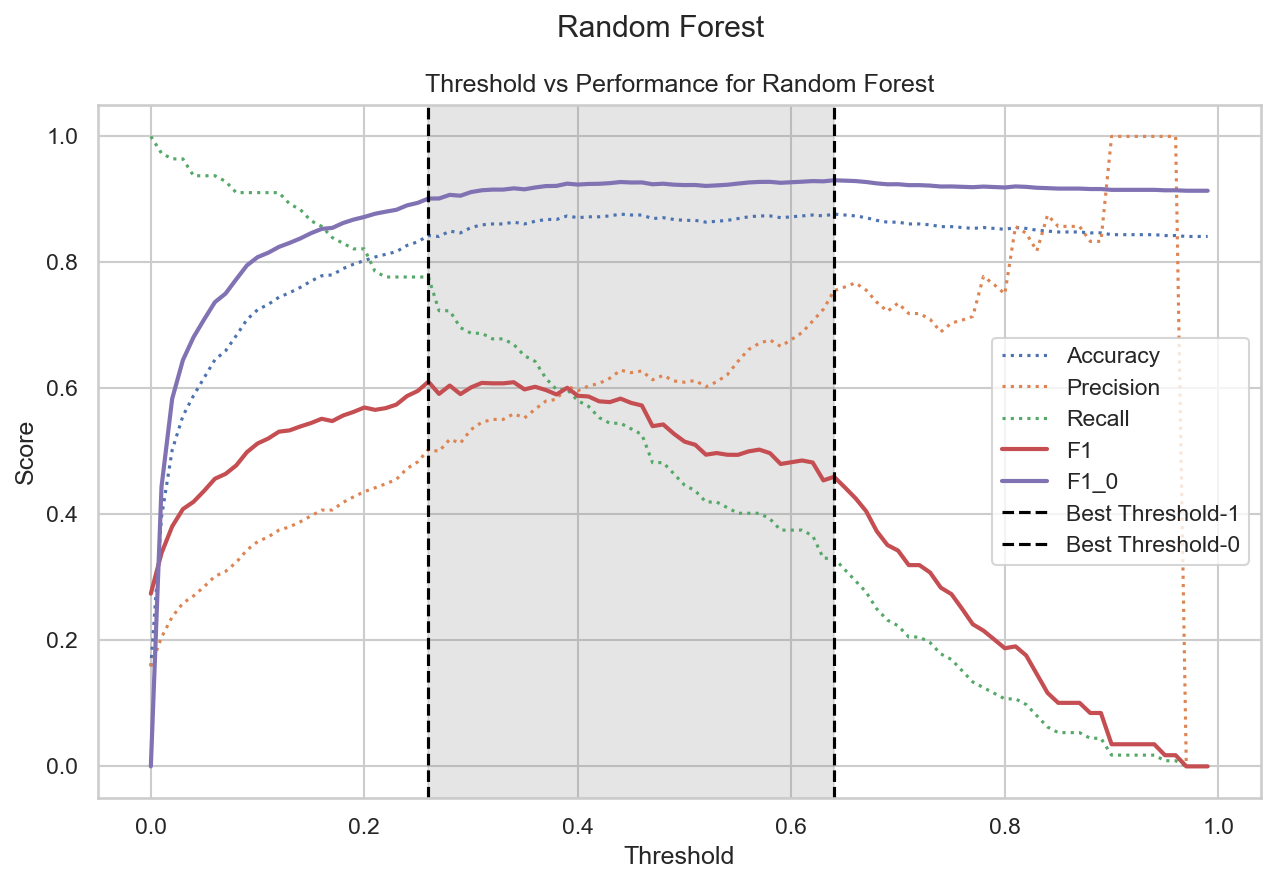

In [29]:
thresholds = np.arange(0, 1, 0.01)
results_df_res = gin.validate.evaluate_thresholds(model_res, X_test,
                                                  y_test, thresholds)
results_df = gin.validate.evaluate_thresholds(model, X_test, y_test,
                                              thresholds)
gin.validate.plot_threshold_results(results_df_res, model_name='Random Forest', suptitle='Random Forest - Resampled')
gin.validate.plot_threshold_results(results_df, model_name='Random Forest', suptitle='Random Forest')

## Conclusion

Class imbalance correction creates a modest improvement.

The correct threshold depends on what we're optimizing for: do we want to balance precision recall for floral molecules or non-floral?

Generally, we should pick a threshold somewhere in the goldilocks zone (shown in gray above).

# Multi-layer Perceptron 
Let's traina simple neural network.

Now that we have tried modeling with an RF, let's try modeling with a simple neural network: the [multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron).

This exercise aims to see whether we can train a PyTorch neural network from end to end, so a simple sanity check is adequate, and a thorough evaluation is **not** required.

## Build the MLP module and model API

## Setup a simple data loader and train the model

In [30]:
from gin.model import MLP
model = MLP(input_dim=X_train.shape[1])
model.fit(X_train, y_train)

model_res = MLP(input_dim=X_train_res.shape[1])
model_res.fit(X_train_res, y_train_res)

Epochs: 100%|█████████████████████████████████████████████████████████████████████| 200/200 [00:12<00:00, 16.28it/s]


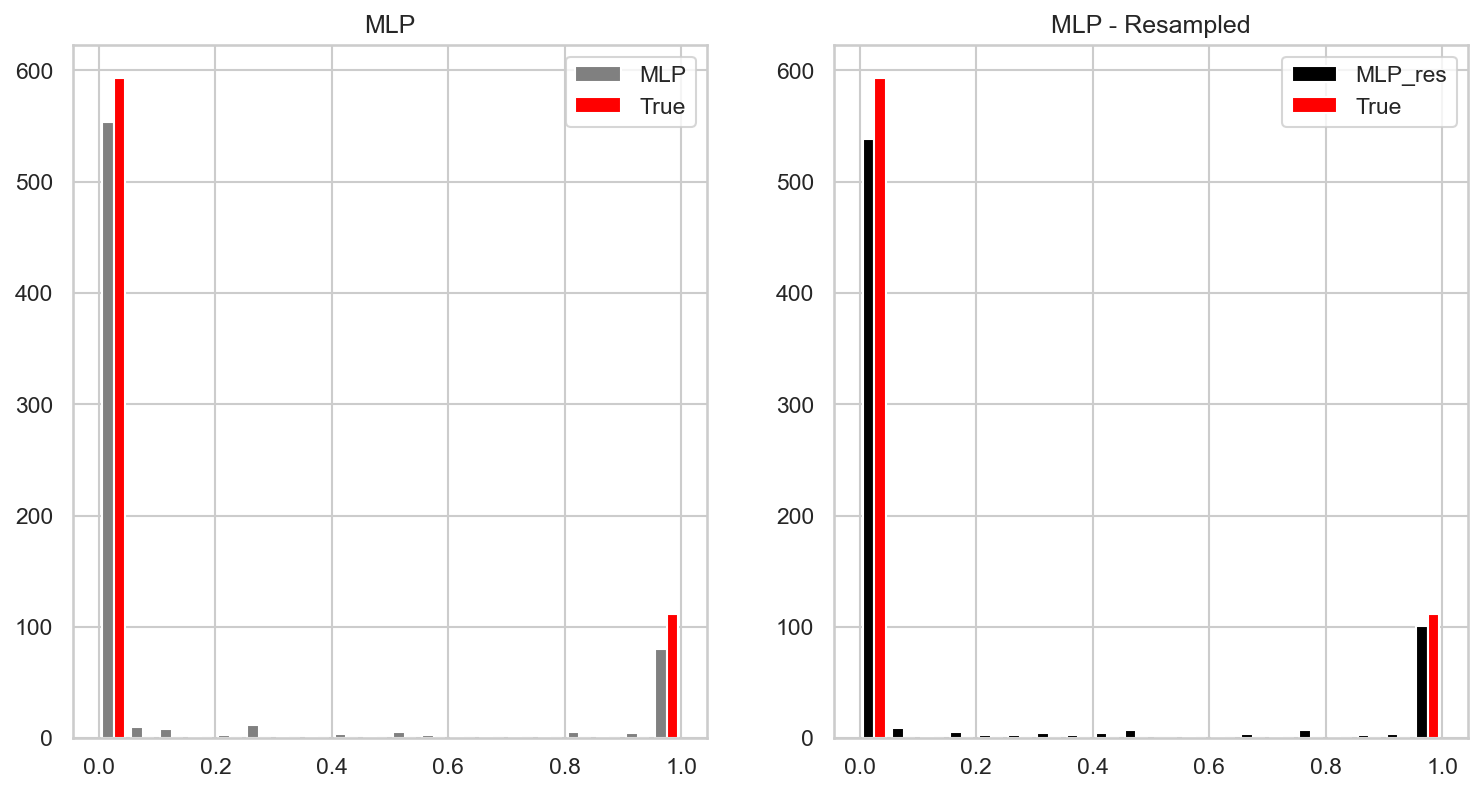

In [31]:
# Sanity check — how do we know the model has learned from the data?
mlp_y_pred = model.predict(X_test)
mlp_y_pred_res = model_res.predict(X_test)
mlp_y_pred_res2uns = model_res.predict(X_test)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist([mlp_y_pred, y_test], bins=20, label=['MLP', 'True'], color=['gray', 'red'])
axs[1].hist([mlp_y_pred_res2uns, y_test], bins=20, label=['MLP_res', 'True'], color=['black', 'red'])
axs[0].set_title('MLP')
axs[1].set_title('MLP - Resampled')
axs[0].legend()
axs[1].legend()
plt.show()

----------------
MLP
----------------
Accuracy: 0.8539007092198582
Precision: 0.5420560747663551
Recall: 0.5178571428571429
F1 Score: 0.5296803652968036
F1 Score0: 0.9135180520570949
AUC-ROC Score: N/A


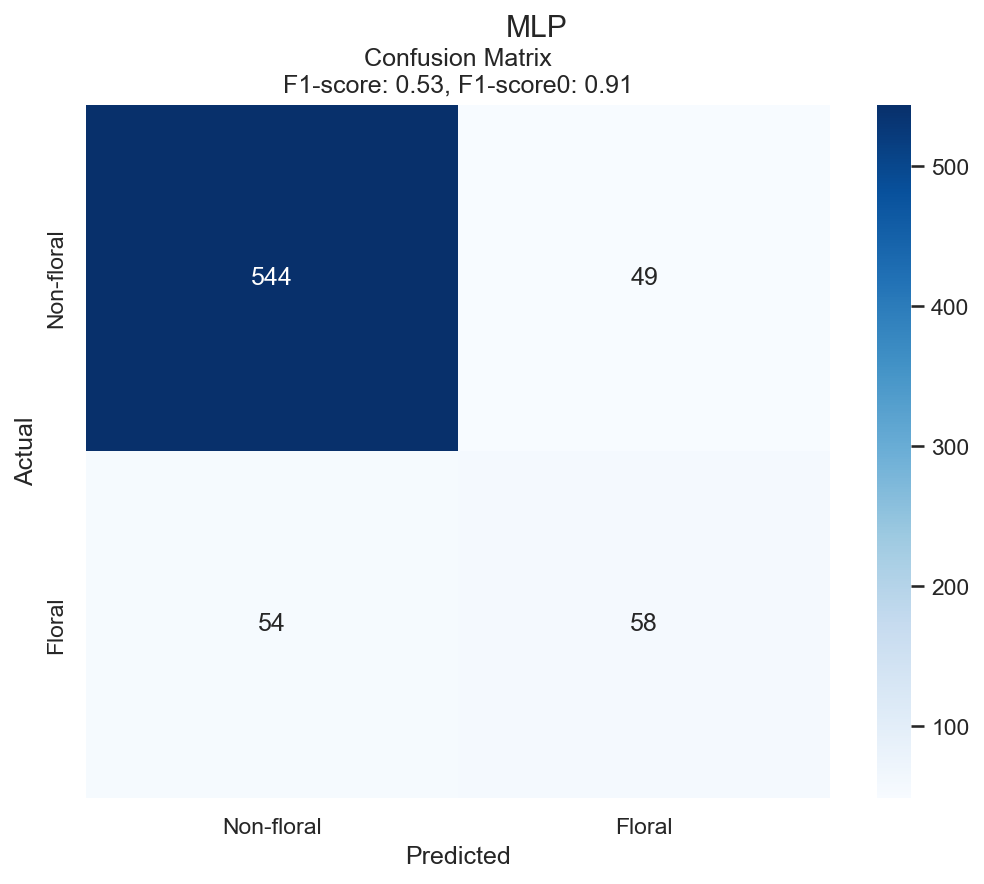

----------------
MLP - Resampled
----------------
Accuracy: 0.851063829787234
Precision: 0.528
Recall: 0.5892857142857143
F1 Score: 0.5569620253164557
F1 Score0: 0.9104859335038363
AUC-ROC Score: N/A


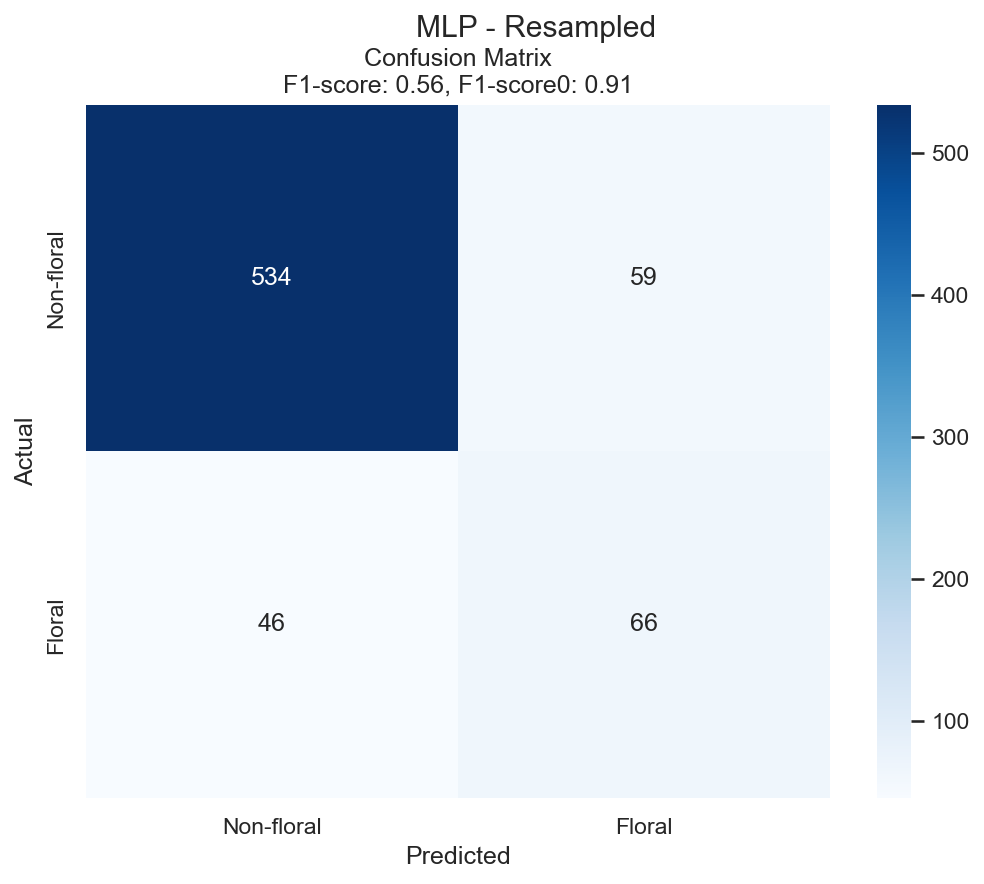

In [32]:
# As before, let's just explore the default threshold > 0.5
print("----------------")
print("MLP")
print("----------------")
suptitle = 'MLP'
gin.validate.evaluate_model(y_test, mlp_y_pred>0.5)
gin.validate.plot_confusion_matrix(y_test, mlp_y_pred>0.5, suptitle=suptitle)

print("----------------")
print("MLP - Resampled")
print("----------------")
suptitle = 'MLP - Resampled'
gin.validate.evaluate_model(y_test, mlp_y_pred_res2uns > 0.5)
gin.validate.plot_confusion_matrix(y_test, mlp_y_pred_res2uns>0.5, suptitle=suptitle)

Let's also try to examine the threshold for the MLP's final sigmoid output.

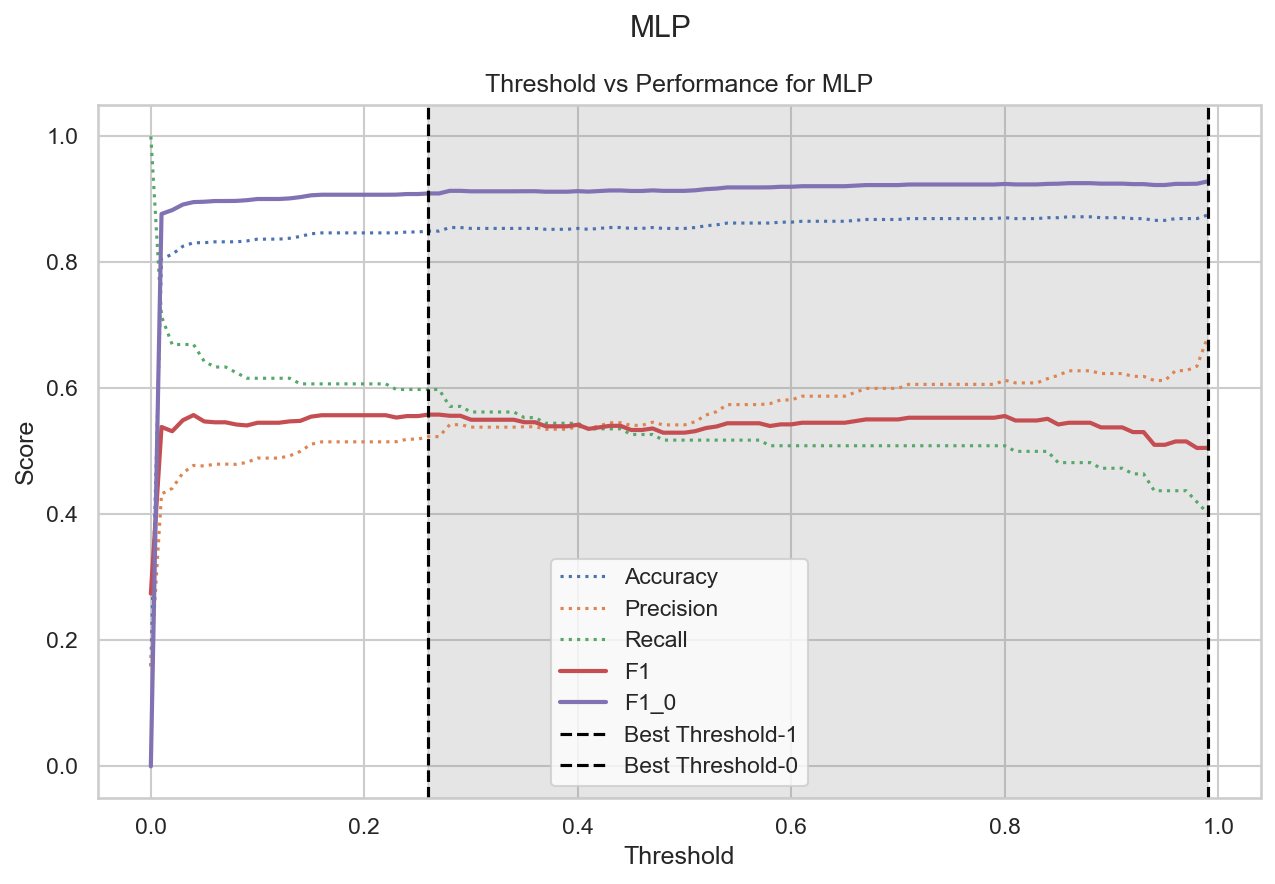

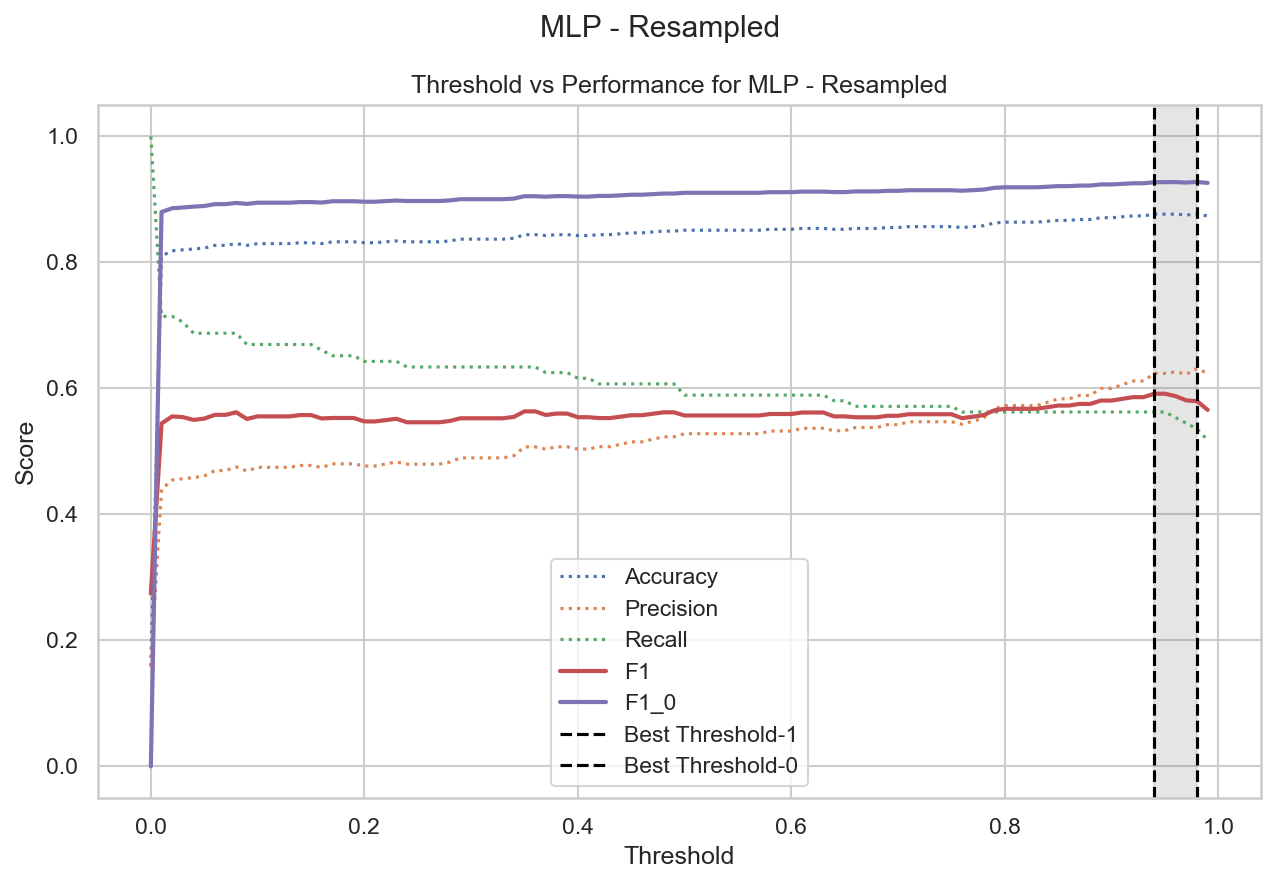

In [33]:
results_df_mlp = gin.validate.evaluate_thresholds(model,
                                                  X_test,
                                                  y_test,
                                                  thresholds,
                                                  y_proba=mlp_y_pred)
results_df_mlp_res = gin.validate.evaluate_thresholds(model_res,
                                                      X_test,
                                                      y_test,
                                                      thresholds,
                                                      y_proba=mlp_y_pred_res)
gin.validate.plot_threshold_results(results_df_mlp, model_name='MLP', suptitle='MLP')
gin.validate.plot_threshold_results(results_df_mlp_res, model_name='MLP - Resampled', suptitle='MLP - Resampled')

## Conclusions

The `MLP` achieves a very similar performance to the simpler method above.

Notably, the resampled model for the `MLP` does **not** perform any better, unlike the `RandomForest` above. In practice, we could try other methods of rebalancing and data augmentation techniques given sparse samples.

# Graph Neural Network, Bonus - Naive (👶) 

For fun, let's dovetail this section with a very naive message-passing GNN approach  🤖

*NOTES OF INTEREST*  📝
- We are doing this without resampling/data-augmentation -- so we _may not approach_ performance above.
- Instead, using a simpler class-imbalance reweighting function in the cross-entropy objective.
- We may not have enough samples to utilize the capacity of a bigger model.

In [34]:
# Convert the SMILES strings to graph data and split into train/test sets
from sklearn.model_selection import train_test_split
import torch
from torch_geometric.data import DataLoader
from gin.extra.features import smiles_to_graph
from gin.extra.gnn import train_gnn_model

# Convert the SMILES strings to graph data
data_list = []
for smile_string, floral in zip(data_df.index, data_df['floral']):
    data = smiles_to_graph(smile_string)
    if data is not None:
        data.y = torch.tensor([floral], dtype=torch.float)  # Assign target value
        data_list.append(data)
data_list = gin.extra.features.normalize_data_list(data_list) # Normalize features

if len(data_list) == 0:
    raise ValueError("No valid graph data could be generated from the provided SMILES strings.")

# Split the data into training and testing sets
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42)

Train

In [35]:
# Train the GNN model on the training data with SMOTE applied
model = train_gnn_model(train_data, num_epochs=250)

/Users/ryoung/Code/repos/SMELL/DREAM/env/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Epochs:   0%|▎                                                                      | 1/250 [00:00<03:19,  1.25it/s]

Epoch 1, Loss: 0.1824


Epochs:   1%|▌                                                                      | 2/250 [00:01<02:56,  1.40it/s]

Epoch 2, Loss: 0.1838


Epochs:   1%|▊                                                                      | 3/250 [00:02<02:47,  1.48it/s]

Epoch 3, Loss: 0.1813


Epochs:   2%|█▏                                                                     | 4/250 [00:02<02:40,  1.53it/s]

Epoch 4, Loss: 0.1807


Epochs:   2%|█▍                                                                     | 5/250 [00:03<02:40,  1.53it/s]

Epoch 5, Loss: 0.1790


Epochs:   2%|█▋                                                                     | 6/250 [00:03<02:37,  1.54it/s]

Epoch 6, Loss: 0.1773


Epochs:   3%|█▉                                                                     | 7/250 [00:04<02:32,  1.60it/s]

Epoch 7, Loss: 0.1754


Epochs:   3%|██▎                                                                    | 8/250 [00:05<02:35,  1.56it/s]

Epoch 8, Loss: 0.1728


Epochs:   4%|██▌                                                                    | 9/250 [00:05<02:34,  1.56it/s]

Epoch 9, Loss: 0.1686


Epochs:   4%|██▊                                                                   | 10/250 [00:06<02:31,  1.59it/s]

Epoch 10, Loss: 0.1647


Epochs:   4%|███                                                                   | 11/250 [00:07<02:25,  1.64it/s]

Epoch 11, Loss: 0.1567


Epochs:   5%|███▎                                                                  | 12/250 [00:07<02:27,  1.62it/s]

Epoch 12, Loss: 0.1516


Epochs:   5%|███▋                                                                  | 13/250 [00:08<02:20,  1.68it/s]

Epoch 13, Loss: 0.1533


Epochs:   6%|███▉                                                                  | 14/250 [00:08<02:16,  1.72it/s]

Epoch 14, Loss: 0.1506


Epochs:   6%|████▏                                                                 | 15/250 [00:09<02:14,  1.74it/s]

Epoch 15, Loss: 0.1482


Epochs:   6%|████▍                                                                 | 16/250 [00:09<02:17,  1.70it/s]

Epoch 16, Loss: 0.1494


Epochs:   7%|████▊                                                                 | 17/250 [00:10<02:16,  1.71it/s]

Epoch 17, Loss: 0.1462


Epochs:   7%|█████                                                                 | 18/250 [00:11<02:17,  1.68it/s]

Epoch 18, Loss: 0.1451


Epochs:   8%|█████▎                                                                | 19/250 [00:11<02:13,  1.73it/s]

Epoch 19, Loss: 0.1579


Epochs:   8%|█████▌                                                                | 20/250 [00:12<02:13,  1.73it/s]

Epoch 20, Loss: 0.1464


Epochs:   8%|█████▉                                                                | 21/250 [00:12<02:13,  1.72it/s]

Epoch 21, Loss: 0.1474


Epochs:   9%|██████▏                                                               | 22/250 [00:13<02:10,  1.75it/s]

Epoch 22, Loss: 0.1492


Epochs:   9%|██████▍                                                               | 23/250 [00:14<02:11,  1.73it/s]

Epoch 23, Loss: 0.1477


Epochs:  10%|██████▋                                                               | 24/250 [00:14<02:15,  1.66it/s]

Epoch 24, Loss: 0.1495


Epochs:  10%|███████                                                               | 25/250 [00:15<02:15,  1.65it/s]

Epoch 25, Loss: 0.1461


Epochs:  10%|███████▎                                                              | 26/250 [00:15<02:18,  1.62it/s]

Epoch 26, Loss: 0.1455


Epochs:  11%|███████▌                                                              | 27/250 [00:16<02:17,  1.62it/s]

Epoch 27, Loss: 0.1469


Epochs:  11%|███████▊                                                              | 28/250 [00:17<02:20,  1.58it/s]

Epoch 28, Loss: 0.1438


Epochs:  12%|████████                                                              | 29/250 [00:17<02:18,  1.60it/s]

Epoch 29, Loss: 0.1449


Epochs:  12%|████████▍                                                             | 30/250 [00:18<02:18,  1.59it/s]

Epoch 30, Loss: 0.1428


Epochs:  12%|████████▋                                                             | 31/250 [00:19<02:18,  1.59it/s]

Epoch 31, Loss: 0.1417


Epochs:  13%|████████▉                                                             | 32/250 [00:19<02:27,  1.48it/s]

Epoch 32, Loss: 0.1451


Epochs:  13%|█████████▏                                                            | 33/250 [00:20<02:28,  1.46it/s]

Epoch 33, Loss: 0.1420


Epochs:  14%|█████████▌                                                            | 34/250 [00:21<02:25,  1.48it/s]

Epoch 34, Loss: 0.1434


Epochs:  14%|█████████▊                                                            | 35/250 [00:21<02:20,  1.53it/s]

Epoch 35, Loss: 0.1390


Epochs:  14%|██████████                                                            | 36/250 [00:22<02:23,  1.50it/s]

Epoch 36, Loss: 0.1411


Epochs:  15%|██████████▎                                                           | 37/250 [00:23<02:18,  1.54it/s]

Epoch 37, Loss: 0.1382


Epochs:  15%|██████████▋                                                           | 38/250 [00:23<02:17,  1.54it/s]

Epoch 38, Loss: 0.1375


Epochs:  16%|██████████▉                                                           | 39/250 [00:24<02:12,  1.59it/s]

Epoch 39, Loss: 0.1370


Epochs:  16%|███████████▏                                                          | 40/250 [00:24<02:09,  1.62it/s]

Epoch 40, Loss: 0.1371


Epochs:  16%|███████████▍                                                          | 41/250 [00:25<02:07,  1.64it/s]

Epoch 41, Loss: 0.1405


Epochs:  17%|███████████▊                                                          | 42/250 [00:26<02:10,  1.60it/s]

Epoch 42, Loss: 0.1407


Epochs:  17%|████████████                                                          | 43/250 [00:27<02:33,  1.35it/s]

Epoch 43, Loss: 0.1368


Epochs:  18%|████████████▎                                                         | 44/250 [00:28<02:39,  1.29it/s]

Epoch 44, Loss: 0.1377


Epochs:  18%|████████████▌                                                         | 45/250 [00:28<02:39,  1.29it/s]

Epoch 45, Loss: 0.1341


Epochs:  18%|████████████▉                                                         | 46/250 [00:29<02:45,  1.23it/s]

Epoch 46, Loss: 0.1318


Epochs:  19%|█████████████▏                                                        | 47/250 [00:30<02:38,  1.28it/s]

Epoch 47, Loss: 0.1331


Epochs:  19%|█████████████▍                                                        | 48/250 [00:31<02:35,  1.30it/s]

Epoch 48, Loss: 0.1323


Epochs:  20%|█████████████▋                                                        | 49/250 [00:31<02:34,  1.30it/s]

Epoch 49, Loss: 0.1285


Epochs:  20%|██████████████                                                        | 50/250 [00:32<02:44,  1.22it/s]

Epoch 50, Loss: 0.1312


Epochs:  20%|██████████████▎                                                       | 51/250 [00:33<02:46,  1.20it/s]

Epoch 51, Loss: 0.1283


Epochs:  21%|██████████████▌                                                       | 52/250 [00:34<02:38,  1.25it/s]

Epoch 52, Loss: 0.1316


Epochs:  21%|██████████████▊                                                       | 53/250 [00:35<02:27,  1.33it/s]

Epoch 53, Loss: 0.1280


Epochs:  22%|███████████████                                                       | 54/250 [00:35<02:25,  1.34it/s]

Epoch 54, Loss: 0.1311


Epochs:  22%|███████████████▍                                                      | 55/250 [00:36<02:18,  1.41it/s]

Epoch 55, Loss: 0.1274


Epochs:  22%|███████████████▋                                                      | 56/250 [00:37<02:10,  1.49it/s]

Epoch 56, Loss: 0.1274


Epochs:  23%|███████████████▉                                                      | 57/250 [00:37<02:05,  1.53it/s]

Epoch 57, Loss: 0.1285


Epochs:  23%|████████████████▏                                                     | 58/250 [00:38<02:04,  1.54it/s]

Epoch 58, Loss: 0.1275


Epochs:  24%|████████████████▌                                                     | 59/250 [00:38<02:03,  1.55it/s]

Epoch 59, Loss: 0.1278


Epochs:  24%|████████████████▊                                                     | 60/250 [00:39<02:00,  1.58it/s]

Epoch 60, Loss: 0.1277


Epochs:  24%|█████████████████                                                     | 61/250 [00:40<01:59,  1.58it/s]

Epoch 61, Loss: 0.1303


Epochs:  25%|█████████████████▎                                                    | 62/250 [00:40<01:57,  1.60it/s]

Epoch 62, Loss: 0.1288


Epochs:  25%|█████████████████▋                                                    | 63/250 [00:41<01:58,  1.58it/s]

Epoch 63, Loss: 0.1296


Epochs:  26%|█████████████████▉                                                    | 64/250 [00:42<01:59,  1.56it/s]

Epoch 64, Loss: 0.1280


Epochs:  26%|██████████████████▏                                                   | 65/250 [00:42<02:03,  1.49it/s]

Epoch 65, Loss: 0.1305


Epochs:  26%|██████████████████▍                                                   | 66/250 [00:43<02:09,  1.42it/s]

Epoch 66, Loss: 0.1291


Epochs:  27%|██████████████████▊                                                   | 67/250 [00:44<02:15,  1.35it/s]

Epoch 67, Loss: 0.1287


Epochs:  27%|███████████████████                                                   | 68/250 [00:45<02:15,  1.34it/s]

Epoch 68, Loss: 0.1297


Epochs:  28%|███████████████████▎                                                  | 69/250 [00:45<02:12,  1.37it/s]

Epoch 69, Loss: 0.1276


Epochs:  28%|███████████████████▌                                                  | 70/250 [00:46<02:06,  1.42it/s]

Epoch 70, Loss: 0.1276


Epochs:  28%|███████████████████▉                                                  | 71/250 [00:47<02:05,  1.42it/s]

Epoch 71, Loss: 0.1278


Epochs:  29%|████████████████████▏                                                 | 72/250 [00:47<02:01,  1.46it/s]

Epoch 72, Loss: 0.1272


Epochs:  29%|████████████████████▍                                                 | 73/250 [00:48<01:58,  1.50it/s]

Epoch 73, Loss: 0.1264


Epochs:  30%|████████████████████▋                                                 | 74/250 [00:49<01:54,  1.54it/s]

Epoch 74, Loss: 0.1280


Epochs:  30%|█████████████████████                                                 | 75/250 [00:49<01:52,  1.55it/s]

Epoch 75, Loss: 0.1272


Epochs:  30%|█████████████████████▎                                                | 76/250 [00:50<01:53,  1.54it/s]

Epoch 76, Loss: 0.1285


Epochs:  31%|█████████████████████▌                                                | 77/250 [00:51<01:52,  1.54it/s]

Epoch 77, Loss: 0.1295


Epochs:  31%|█████████████████████▊                                                | 78/250 [00:51<01:49,  1.57it/s]

Epoch 78, Loss: 0.1266


Epochs:  32%|██████████████████████                                                | 79/250 [00:52<01:50,  1.55it/s]

Epoch 79, Loss: 0.1270


Epochs:  32%|██████████████████████▍                                               | 80/250 [00:53<01:58,  1.43it/s]

Epoch 80, Loss: 0.1269


Epochs:  32%|██████████████████████▋                                               | 81/250 [00:53<02:02,  1.38it/s]

Epoch 81, Loss: 0.1269


Epochs:  33%|██████████████████████▉                                               | 82/250 [00:54<02:06,  1.33it/s]

Epoch 82, Loss: 0.1275


Epochs:  33%|███████████████████████▏                                              | 83/250 [00:55<02:05,  1.33it/s]

Epoch 83, Loss: 0.1247


Epochs:  34%|███████████████████████▌                                              | 84/250 [00:56<02:02,  1.35it/s]

Epoch 84, Loss: 0.1259


Epochs:  34%|███████████████████████▊                                              | 85/250 [00:57<02:05,  1.32it/s]

Epoch 85, Loss: 0.1258


Epochs:  34%|████████████████████████                                              | 86/250 [00:57<02:01,  1.35it/s]

Epoch 86, Loss: 0.1272


Epochs:  35%|████████████████████████▎                                             | 87/250 [00:58<01:58,  1.37it/s]

Epoch 87, Loss: 0.1270


Epochs:  35%|████████████████████████▋                                             | 88/250 [00:59<01:56,  1.39it/s]

Epoch 88, Loss: 0.1241


Epochs:  36%|████████████████████████▉                                             | 89/250 [00:59<01:53,  1.41it/s]

Epoch 89, Loss: 0.1255


Epochs:  36%|█████████████████████████▏                                            | 90/250 [01:00<01:51,  1.44it/s]

Epoch 90, Loss: 0.1268


Epochs:  36%|█████████████████████████▍                                            | 91/250 [01:01<01:49,  1.46it/s]

Epoch 91, Loss: 0.1254


Epochs:  37%|█████████████████████████▊                                            | 92/250 [01:01<01:53,  1.39it/s]

Epoch 92, Loss: 0.1274


Epochs:  37%|██████████████████████████                                            | 93/250 [01:02<01:58,  1.33it/s]

Epoch 93, Loss: 0.1255


Epochs:  38%|██████████████████████████▎                                           | 94/250 [01:03<01:56,  1.34it/s]

Epoch 94, Loss: 0.1245


Epochs:  38%|██████████████████████████▌                                           | 95/250 [01:04<01:52,  1.38it/s]

Epoch 95, Loss: 0.1250


Epochs:  38%|██████████████████████████▉                                           | 96/250 [01:04<01:51,  1.38it/s]

Epoch 96, Loss: 0.1266


Epochs:  39%|███████████████████████████▏                                          | 97/250 [01:05<01:46,  1.44it/s]

Epoch 97, Loss: 0.1231


Epochs:  39%|███████████████████████████▍                                          | 98/250 [01:06<01:45,  1.44it/s]

Epoch 98, Loss: 0.1234


Epochs:  40%|███████████████████████████▋                                          | 99/250 [01:06<01:44,  1.44it/s]

Epoch 99, Loss: 0.1267


Epochs:  40%|███████████████████████████▌                                         | 100/250 [01:07<01:42,  1.46it/s]

Epoch 100, Loss: 0.1206


Epochs:  40%|███████████████████████████▉                                         | 101/250 [01:08<01:44,  1.43it/s]

Epoch 101, Loss: 0.1279


Epochs:  41%|████████████████████████████▏                                        | 102/250 [01:09<01:44,  1.41it/s]

Epoch 102, Loss: 0.1256


Epochs:  41%|████████████████████████████▍                                        | 103/250 [01:09<01:43,  1.42it/s]

Epoch 103, Loss: 0.1260


Epochs:  42%|████████████████████████████▋                                        | 104/250 [01:10<01:42,  1.43it/s]

Epoch 104, Loss: 0.1260


Epochs:  42%|████████████████████████████▉                                        | 105/250 [01:11<01:40,  1.44it/s]

Epoch 105, Loss: 0.1224


Epochs:  42%|█████████████████████████████▎                                       | 106/250 [01:12<01:50,  1.30it/s]

Epoch 106, Loss: 0.1242


Epochs:  43%|█████████████████████████████▌                                       | 107/250 [01:12<01:49,  1.31it/s]

Epoch 107, Loss: 0.1261


Epochs:  43%|█████████████████████████████▊                                       | 108/250 [01:13<01:46,  1.34it/s]

Epoch 108, Loss: 0.1243


Epochs:  44%|██████████████████████████████                                       | 109/250 [01:14<01:42,  1.38it/s]

Epoch 109, Loss: 0.1263


Epochs:  44%|██████████████████████████████▎                                      | 110/250 [01:14<01:37,  1.44it/s]

Epoch 110, Loss: 0.1242


Epochs:  44%|██████████████████████████████▋                                      | 111/250 [01:15<01:35,  1.46it/s]

Epoch 111, Loss: 0.1248


Epochs:  45%|██████████████████████████████▉                                      | 112/250 [01:16<01:32,  1.50it/s]

Epoch 112, Loss: 0.1240


Epochs:  45%|███████████████████████████████▏                                     | 113/250 [01:16<01:33,  1.46it/s]

Epoch 113, Loss: 0.1242


Epochs:  46%|███████████████████████████████▍                                     | 114/250 [01:17<01:38,  1.38it/s]

Epoch 114, Loss: 0.1241


Epochs:  46%|███████████████████████████████▋                                     | 115/250 [01:18<01:40,  1.34it/s]

Epoch 115, Loss: 0.1240


Epochs:  46%|████████████████████████████████                                     | 116/250 [01:19<01:41,  1.32it/s]

Epoch 116, Loss: 0.1252


Epochs:  47%|████████████████████████████████▎                                    | 117/250 [01:20<01:41,  1.31it/s]

Epoch 117, Loss: 0.1254


Epochs:  47%|████████████████████████████████▌                                    | 118/250 [01:20<01:42,  1.28it/s]

Epoch 118, Loss: 0.1225


Epochs:  48%|████████████████████████████████▊                                    | 119/250 [01:21<01:38,  1.32it/s]

Epoch 119, Loss: 0.1207


Epochs:  48%|█████████████████████████████████                                    | 120/250 [01:22<01:38,  1.32it/s]

Epoch 120, Loss: 0.1245


Epochs:  48%|█████████████████████████████████▍                                   | 121/250 [01:23<01:37,  1.32it/s]

Epoch 121, Loss: 0.1229


Epochs:  49%|█████████████████████████████████▋                                   | 122/250 [01:23<01:35,  1.34it/s]

Epoch 122, Loss: 0.1245


Epochs:  49%|█████████████████████████████████▉                                   | 123/250 [01:24<01:32,  1.37it/s]

Epoch 123, Loss: 0.1238


Epochs:  50%|██████████████████████████████████▏                                  | 124/250 [01:25<01:30,  1.40it/s]

Epoch 124, Loss: 0.1270


Epochs:  50%|██████████████████████████████████▌                                  | 125/250 [01:25<01:25,  1.47it/s]

Epoch 125, Loss: 0.1241


Epochs:  50%|██████████████████████████████████▊                                  | 126/250 [01:26<01:23,  1.49it/s]

Epoch 126, Loss: 0.1231


Epochs:  51%|███████████████████████████████████                                  | 127/250 [01:27<01:23,  1.48it/s]

Epoch 127, Loss: 0.1239


Epochs:  51%|███████████████████████████████████▎                                 | 128/250 [01:27<01:23,  1.47it/s]

Epoch 128, Loss: 0.1247


Epochs:  52%|███████████████████████████████████▌                                 | 129/250 [01:28<01:18,  1.54it/s]

Epoch 129, Loss: 0.1223


Epochs:  52%|███████████████████████████████████▉                                 | 130/250 [01:28<01:17,  1.55it/s]

Epoch 130, Loss: 0.1251


Epochs:  52%|████████████████████████████████████▏                                | 131/250 [01:29<01:15,  1.57it/s]

Epoch 131, Loss: 0.1246


Epochs:  53%|████████████████████████████████████▍                                | 132/250 [01:30<01:16,  1.55it/s]

Epoch 132, Loss: 0.1243


Epochs:  53%|████████████████████████████████████▋                                | 133/250 [01:30<01:18,  1.50it/s]

Epoch 133, Loss: 0.1230


Epochs:  54%|████████████████████████████████████▉                                | 134/250 [01:31<01:16,  1.51it/s]

Epoch 134, Loss: 0.1258


Epochs:  54%|█████████████████████████████████████▎                               | 135/250 [01:32<01:16,  1.50it/s]

Epoch 135, Loss: 0.1252


Epochs:  54%|█████████████████████████████████████▌                               | 136/250 [01:33<01:27,  1.30it/s]

Epoch 136, Loss: 0.1228


Epochs:  55%|█████████████████████████████████████▊                               | 137/250 [01:34<01:26,  1.30it/s]

Epoch 137, Loss: 0.1247


Epochs:  55%|██████████████████████████████████████                               | 138/250 [01:34<01:28,  1.26it/s]

Epoch 138, Loss: 0.1233


Epochs:  56%|██████████████████████████████████████▎                              | 139/250 [01:35<01:24,  1.31it/s]

Epoch 139, Loss: 0.1271


Epochs:  56%|██████████████████████████████████████▋                              | 140/250 [01:36<01:26,  1.27it/s]

Epoch 140, Loss: 0.1222


Epochs:  56%|██████████████████████████████████████▉                              | 141/250 [01:37<01:22,  1.32it/s]

Epoch 141, Loss: 0.1244


Epochs:  57%|███████████████████████████████████████▏                             | 142/250 [01:37<01:21,  1.33it/s]

Epoch 142, Loss: 0.1248


Epochs:  57%|███████████████████████████████████████▍                             | 143/250 [01:38<01:19,  1.35it/s]

Epoch 143, Loss: 0.1246


Epochs:  58%|███████████████████████████████████████▋                             | 144/250 [01:39<01:21,  1.29it/s]

Epoch 144, Loss: 0.1239


Epochs:  58%|████████████████████████████████████████                             | 145/250 [01:40<01:17,  1.35it/s]

Epoch 145, Loss: 0.1225


Epochs:  58%|████████████████████████████████████████▎                            | 146/250 [01:40<01:13,  1.42it/s]

Epoch 146, Loss: 0.1248


Epochs:  59%|████████████████████████████████████████▌                            | 147/250 [01:41<01:09,  1.48it/s]

Epoch 147, Loss: 0.1223


Epochs:  59%|████████████████████████████████████████▊                            | 148/250 [01:41<01:06,  1.53it/s]

Epoch 148, Loss: 0.1238


Epochs:  60%|█████████████████████████████████████████                            | 149/250 [01:42<01:10,  1.42it/s]

Epoch 149, Loss: 0.1228


Epochs:  60%|█████████████████████████████████████████▍                           | 150/250 [01:43<01:16,  1.31it/s]

Epoch 150, Loss: 0.1241


Epochs:  60%|█████████████████████████████████████████▋                           | 151/250 [01:44<01:14,  1.34it/s]

Epoch 151, Loss: 0.1225


Epochs:  61%|█████████████████████████████████████████▉                           | 152/250 [01:45<01:10,  1.40it/s]

Epoch 152, Loss: 0.1258


Epochs:  61%|██████████████████████████████████████████▏                          | 153/250 [01:45<01:11,  1.36it/s]

Epoch 153, Loss: 0.1233


Epochs:  62%|██████████████████████████████████████████▌                          | 154/250 [01:46<01:18,  1.22it/s]

Epoch 154, Loss: 0.1227


Epochs:  62%|██████████████████████████████████████████▊                          | 155/250 [01:47<01:11,  1.33it/s]

Epoch 155, Loss: 0.1235


Epochs:  62%|███████████████████████████████████████████                          | 156/250 [01:48<01:08,  1.37it/s]

Epoch 156, Loss: 0.1242


Epochs:  63%|███████████████████████████████████████████▎                         | 157/250 [01:48<01:06,  1.41it/s]

Epoch 157, Loss: 0.1224


Epochs:  63%|███████████████████████████████████████████▌                         | 158/250 [01:49<01:05,  1.40it/s]

Epoch 158, Loss: 0.1240


Epochs:  64%|███████████████████████████████████████████▉                         | 159/250 [01:50<01:01,  1.47it/s]

Epoch 159, Loss: 0.1229


Epochs:  64%|████████████████████████████████████████████▏                        | 160/250 [01:50<01:00,  1.48it/s]

Epoch 160, Loss: 0.1244


Epochs:  64%|████████████████████████████████████████████▍                        | 161/250 [01:51<00:57,  1.56it/s]

Epoch 161, Loss: 0.1248


Epochs:  65%|████████████████████████████████████████████▋                        | 162/250 [01:51<00:54,  1.60it/s]

Epoch 162, Loss: 0.1230


Epochs:  65%|████████████████████████████████████████████▉                        | 163/250 [01:52<00:53,  1.63it/s]

Epoch 163, Loss: 0.1218


Epochs:  66%|█████████████████████████████████████████████▎                       | 164/250 [01:53<00:51,  1.65it/s]

Epoch 164, Loss: 0.1247


Epochs:  66%|█████████████████████████████████████████████▌                       | 165/250 [01:53<00:50,  1.69it/s]

Epoch 165, Loss: 0.1266


Epochs:  66%|█████████████████████████████████████████████▊                       | 166/250 [01:54<00:49,  1.71it/s]

Epoch 166, Loss: 0.1248


Epochs:  67%|██████████████████████████████████████████████                       | 167/250 [01:54<00:47,  1.75it/s]

Epoch 167, Loss: 0.1270


Epochs:  67%|██████████████████████████████████████████████▎                      | 168/250 [01:55<00:49,  1.66it/s]

Epoch 168, Loss: 0.1237


Epochs:  68%|██████████████████████████████████████████████▋                      | 169/250 [01:56<00:48,  1.67it/s]

Epoch 169, Loss: 0.1225


Epochs:  68%|██████████████████████████████████████████████▉                      | 170/250 [01:56<00:49,  1.62it/s]

Epoch 170, Loss: 0.1253


Epochs:  68%|███████████████████████████████████████████████▏                     | 171/250 [01:57<00:50,  1.56it/s]

Epoch 171, Loss: 0.1253


Epochs:  69%|███████████████████████████████████████████████▍                     | 172/250 [01:57<00:49,  1.59it/s]

Epoch 172, Loss: 0.1210


Epochs:  69%|███████████████████████████████████████████████▋                     | 173/250 [01:58<00:48,  1.60it/s]

Epoch 173, Loss: 0.1242


Epochs:  70%|████████████████████████████████████████████████                     | 174/250 [01:59<00:46,  1.62it/s]

Epoch 174, Loss: 0.1229


Epochs:  70%|████████████████████████████████████████████████▎                    | 175/250 [01:59<00:46,  1.61it/s]

Epoch 175, Loss: 0.1243


Epochs:  70%|████████████████████████████████████████████████▌                    | 176/250 [02:00<00:45,  1.63it/s]

Epoch 176, Loss: 0.1233


Epochs:  71%|████████████████████████████████████████████████▊                    | 177/250 [02:01<00:45,  1.61it/s]

Epoch 177, Loss: 0.1192


Epochs:  71%|█████████████████████████████████████████████████▏                   | 178/250 [02:01<00:43,  1.64it/s]

Epoch 178, Loss: 0.1247


Epochs:  72%|█████████████████████████████████████████████████▍                   | 179/250 [02:02<00:44,  1.61it/s]

Epoch 179, Loss: 0.1216


Epochs:  72%|█████████████████████████████████████████████████▋                   | 180/250 [02:03<00:49,  1.40it/s]

Epoch 180, Loss: 0.1269


Epochs:  72%|█████████████████████████████████████████████████▉                   | 181/250 [02:04<00:51,  1.34it/s]

Epoch 181, Loss: 0.1284


Epochs:  73%|██████████████████████████████████████████████████▏                  | 182/250 [02:04<00:49,  1.38it/s]

Epoch 182, Loss: 0.1237


Epochs:  73%|██████████████████████████████████████████████████▌                  | 183/250 [02:05<00:47,  1.40it/s]

Epoch 183, Loss: 0.1253


Epochs:  74%|██████████████████████████████████████████████████▊                  | 184/250 [02:06<00:47,  1.39it/s]

Epoch 184, Loss: 0.1216


Epochs:  74%|███████████████████████████████████████████████████                  | 185/250 [02:06<00:46,  1.41it/s]

Epoch 185, Loss: 0.1252


Epochs:  74%|███████████████████████████████████████████████████▎                 | 186/250 [02:07<00:46,  1.38it/s]

Epoch 186, Loss: 0.1223


Epochs:  75%|███████████████████████████████████████████████████▌                 | 187/250 [02:08<00:46,  1.35it/s]

Epoch 187, Loss: 0.1218


Epochs:  75%|███████████████████████████████████████████████████▉                 | 188/250 [02:09<00:46,  1.32it/s]

Epoch 188, Loss: 0.1236


Epochs:  76%|████████████████████████████████████████████████████▏                | 189/250 [02:09<00:46,  1.31it/s]

Epoch 189, Loss: 0.1269


Epochs:  76%|████████████████████████████████████████████████████▍                | 190/250 [02:10<00:43,  1.37it/s]

Epoch 190, Loss: 0.1261


Epochs:  76%|████████████████████████████████████████████████████▋                | 191/250 [02:11<00:42,  1.40it/s]

Epoch 191, Loss: 0.1241


Epochs:  77%|████████████████████████████████████████████████████▉                | 192/250 [02:11<00:40,  1.43it/s]

Epoch 192, Loss: 0.1253


Epochs:  77%|█████████████████████████████████████████████████████▎               | 193/250 [02:12<00:39,  1.44it/s]

Epoch 193, Loss: 0.1232


Epochs:  78%|█████████████████████████████████████████████████████▌               | 194/250 [02:13<00:39,  1.42it/s]

Epoch 194, Loss: 0.1249


Epochs:  78%|█████████████████████████████████████████████████████▊               | 195/250 [02:14<00:39,  1.40it/s]

Epoch 195, Loss: 0.1247


Epochs:  78%|██████████████████████████████████████████████████████               | 196/250 [02:14<00:37,  1.43it/s]

Epoch 196, Loss: 0.1225


Epochs:  79%|██████████████████████████████████████████████████████▎              | 197/250 [02:15<00:35,  1.47it/s]

Epoch 197, Loss: 0.1239


Epochs:  79%|██████████████████████████████████████████████████████▋              | 198/250 [02:16<00:35,  1.47it/s]

Epoch 198, Loss: 0.1224


Epochs:  80%|██████████████████████████████████████████████████████▉              | 199/250 [02:16<00:34,  1.50it/s]

Epoch 199, Loss: 0.1261


Epochs:  80%|███████████████████████████████████████████████████████▏             | 200/250 [02:17<00:32,  1.52it/s]

Epoch 200, Loss: 0.1233


Epochs:  80%|███████████████████████████████████████████████████████▍             | 201/250 [02:17<00:32,  1.50it/s]

Epoch 201, Loss: 0.1247


Epochs:  81%|███████████████████████████████████████████████████████▊             | 202/250 [02:18<00:32,  1.47it/s]

Epoch 202, Loss: 0.1259


Epochs:  81%|████████████████████████████████████████████████████████             | 203/250 [02:19<00:32,  1.46it/s]

Epoch 203, Loss: 0.1252


Epochs:  82%|████████████████████████████████████████████████████████▎            | 204/250 [02:20<00:32,  1.41it/s]

Epoch 204, Loss: 0.1239


Epochs:  82%|████████████████████████████████████████████████████████▌            | 205/250 [02:20<00:32,  1.40it/s]

Epoch 205, Loss: 0.1218


Epochs:  82%|████████████████████████████████████████████████████████▊            | 206/250 [02:21<00:32,  1.35it/s]

Epoch 206, Loss: 0.1235


Epochs:  83%|█████████████████████████████████████████████████████████▏           | 207/250 [02:22<00:31,  1.36it/s]

Epoch 207, Loss: 0.1247


Epochs:  83%|█████████████████████████████████████████████████████████▍           | 208/250 [02:23<00:32,  1.31it/s]

Epoch 208, Loss: 0.1226


Epochs:  84%|█████████████████████████████████████████████████████████▋           | 209/250 [02:23<00:29,  1.38it/s]

Epoch 209, Loss: 0.1261


Epochs:  84%|█████████████████████████████████████████████████████████▉           | 210/250 [02:24<00:27,  1.44it/s]

Epoch 210, Loss: 0.1227


Epochs:  84%|██████████████████████████████████████████████████████████▏          | 211/250 [02:25<00:26,  1.50it/s]

Epoch 211, Loss: 0.1224


Epochs:  85%|██████████████████████████████████████████████████████████▌          | 212/250 [02:25<00:26,  1.43it/s]

Epoch 212, Loss: 0.1260


Epochs:  85%|██████████████████████████████████████████████████████████▊          | 213/250 [02:26<00:25,  1.47it/s]

Epoch 213, Loss: 0.1244


Epochs:  86%|███████████████████████████████████████████████████████████          | 214/250 [02:27<00:24,  1.48it/s]

Epoch 214, Loss: 0.1255


Epochs:  86%|███████████████████████████████████████████████████████████▎         | 215/250 [02:27<00:24,  1.45it/s]

Epoch 215, Loss: 0.1249


Epochs:  86%|███████████████████████████████████████████████████████████▌         | 216/250 [02:28<00:24,  1.36it/s]

Epoch 216, Loss: 0.1234


Epochs:  87%|███████████████████████████████████████████████████████████▉         | 217/250 [02:29<00:24,  1.34it/s]

Epoch 217, Loss: 0.1245


Epochs:  87%|████████████████████████████████████████████████████████████▏        | 218/250 [02:30<00:23,  1.36it/s]

Epoch 218, Loss: 0.1247


Epochs:  88%|████████████████████████████████████████████████████████████▍        | 219/250 [02:30<00:22,  1.35it/s]

Epoch 219, Loss: 0.1258


Epochs:  88%|████████████████████████████████████████████████████████████▋        | 220/250 [02:31<00:22,  1.34it/s]

Epoch 220, Loss: 0.1249


Epochs:  88%|████████████████████████████████████████████████████████████▉        | 221/250 [02:32<00:21,  1.38it/s]

Epoch 221, Loss: 0.1238


Epochs:  89%|█████████████████████████████████████████████████████████████▎       | 222/250 [02:33<00:20,  1.33it/s]

Epoch 222, Loss: 0.1229


Epochs:  89%|█████████████████████████████████████████████████████████████▌       | 223/250 [02:34<00:20,  1.32it/s]

Epoch 223, Loss: 0.1228


Epochs:  90%|█████████████████████████████████████████████████████████████▊       | 224/250 [02:34<00:18,  1.37it/s]

Epoch 224, Loss: 0.1219


Epochs:  90%|██████████████████████████████████████████████████████████████       | 225/250 [02:35<00:17,  1.39it/s]

Epoch 225, Loss: 0.1224


Epochs:  90%|██████████████████████████████████████████████████████████████▍      | 226/250 [02:36<00:16,  1.43it/s]

Epoch 226, Loss: 0.1234


Epochs:  91%|██████████████████████████████████████████████████████████████▋      | 227/250 [02:36<00:16,  1.38it/s]

Epoch 227, Loss: 0.1233


Epochs:  91%|██████████████████████████████████████████████████████████████▉      | 228/250 [02:37<00:15,  1.43it/s]

Epoch 228, Loss: 0.1248


Epochs:  92%|███████████████████████████████████████████████████████████████▏     | 229/250 [02:38<00:14,  1.47it/s]

Epoch 229, Loss: 0.1222


Epochs:  92%|███████████████████████████████████████████████████████████████▍     | 230/250 [02:39<00:16,  1.24it/s]

Epoch 230, Loss: 0.1240


Epochs:  92%|███████████████████████████████████████████████████████████████▊     | 231/250 [02:40<00:15,  1.22it/s]

Epoch 231, Loss: 0.1238


Epochs:  93%|████████████████████████████████████████████████████████████████     | 232/250 [02:40<00:13,  1.29it/s]

Epoch 232, Loss: 0.1219


Epochs:  93%|████████████████████████████████████████████████████████████████▎    | 233/250 [02:41<00:12,  1.36it/s]

Epoch 233, Loss: 0.1214


Epochs:  94%|████████████████████████████████████████████████████████████████▌    | 234/250 [02:42<00:11,  1.39it/s]

Epoch 234, Loss: 0.1231


Epochs:  94%|████████████████████████████████████████████████████████████████▊    | 235/250 [02:42<00:10,  1.45it/s]

Epoch 235, Loss: 0.1240


Epochs:  94%|█████████████████████████████████████████████████████████████████▏   | 236/250 [02:43<00:09,  1.44it/s]

Epoch 236, Loss: 0.1248


Epochs:  95%|█████████████████████████████████████████████████████████████████▍   | 237/250 [02:44<00:08,  1.45it/s]

Epoch 237, Loss: 0.1231


Epochs:  95%|█████████████████████████████████████████████████████████████████▋   | 238/250 [02:44<00:08,  1.49it/s]

Epoch 238, Loss: 0.1240


Epochs:  96%|█████████████████████████████████████████████████████████████████▉   | 239/250 [02:45<00:07,  1.51it/s]

Epoch 239, Loss: 0.1230


Epochs:  96%|██████████████████████████████████████████████████████████████████▏  | 240/250 [02:45<00:06,  1.51it/s]

Epoch 240, Loss: 0.1235


Epochs:  96%|██████████████████████████████████████████████████████████████████▌  | 241/250 [02:46<00:05,  1.55it/s]

Epoch 241, Loss: 0.1219


Epochs:  97%|██████████████████████████████████████████████████████████████████▊  | 242/250 [02:47<00:05,  1.56it/s]

Epoch 242, Loss: 0.1234


Epochs:  97%|███████████████████████████████████████████████████████████████████  | 243/250 [02:47<00:04,  1.50it/s]

Epoch 243, Loss: 0.1237


Epochs:  98%|███████████████████████████████████████████████████████████████████▎ | 244/250 [02:48<00:04,  1.40it/s]

Epoch 244, Loss: 0.1229


Epochs:  98%|███████████████████████████████████████████████████████████████████▌ | 245/250 [02:50<00:04,  1.04it/s]

Epoch 245, Loss: 0.1254


Epochs:  98%|███████████████████████████████████████████████████████████████████▉ | 246/250 [02:51<00:03,  1.12it/s]

Epoch 246, Loss: 0.1231


Epochs:  99%|████████████████████████████████████████████████████████████████████▏| 247/250 [02:51<00:02,  1.21it/s]

Epoch 247, Loss: 0.1217


Epochs:  99%|████████████████████████████████████████████████████████████████████▍| 248/250 [02:52<00:01,  1.26it/s]

Epoch 248, Loss: 0.1265


Epochs: 100%|████████████████████████████████████████████████████████████████████▋| 249/250 [02:53<00:00,  1.30it/s]

Epoch 249, Loss: 0.1255


Epochs: 100%|█████████████████████████████████████████████████████████████████████| 250/250 [02:53<00:00,  1.44it/s]

Epoch 250, Loss: 0.1237


And now, let's run inference

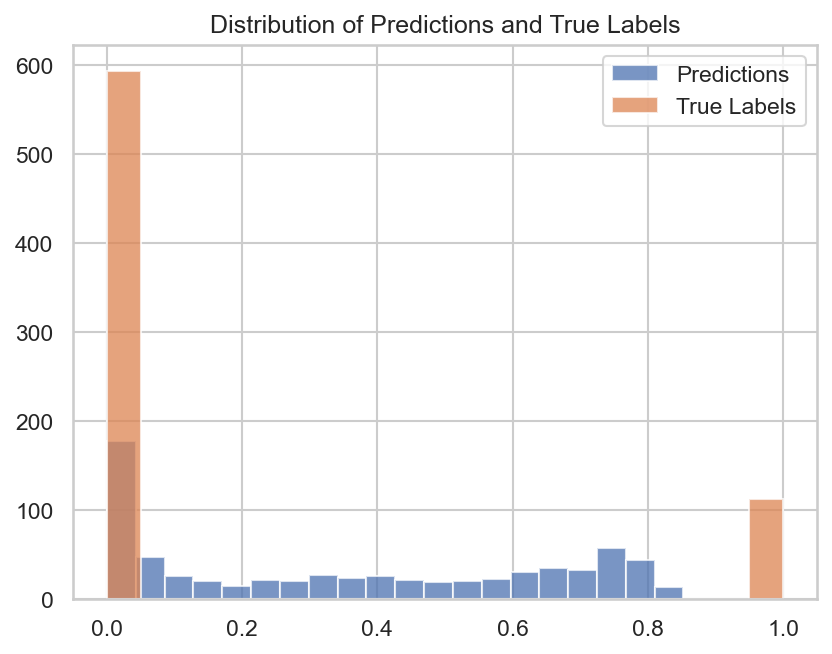

In [36]:
model.eval()
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        preds = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        all_preds.extend(preds.numpy().flatten())
        all_labels.extend(batch.y.numpy().flatten())

import matplotlib.pyplot as plt

plt.hist(all_preds, bins=20, alpha=0.75, label='Predictions')
plt.hist(all_labels, bins=20, alpha=0.75, label='True Labels')
plt.legend()
plt.title('Distribution of Predictions and True Labels')
plt.show()

Accuracy: 0.7205673758865249
Precision: 0.33840304182509506
Recall: 0.7946428571428571
F1 Score: 0.4746666666666667
F1 Score0: 0.8096618357487922
AUC-ROC Score: N/A


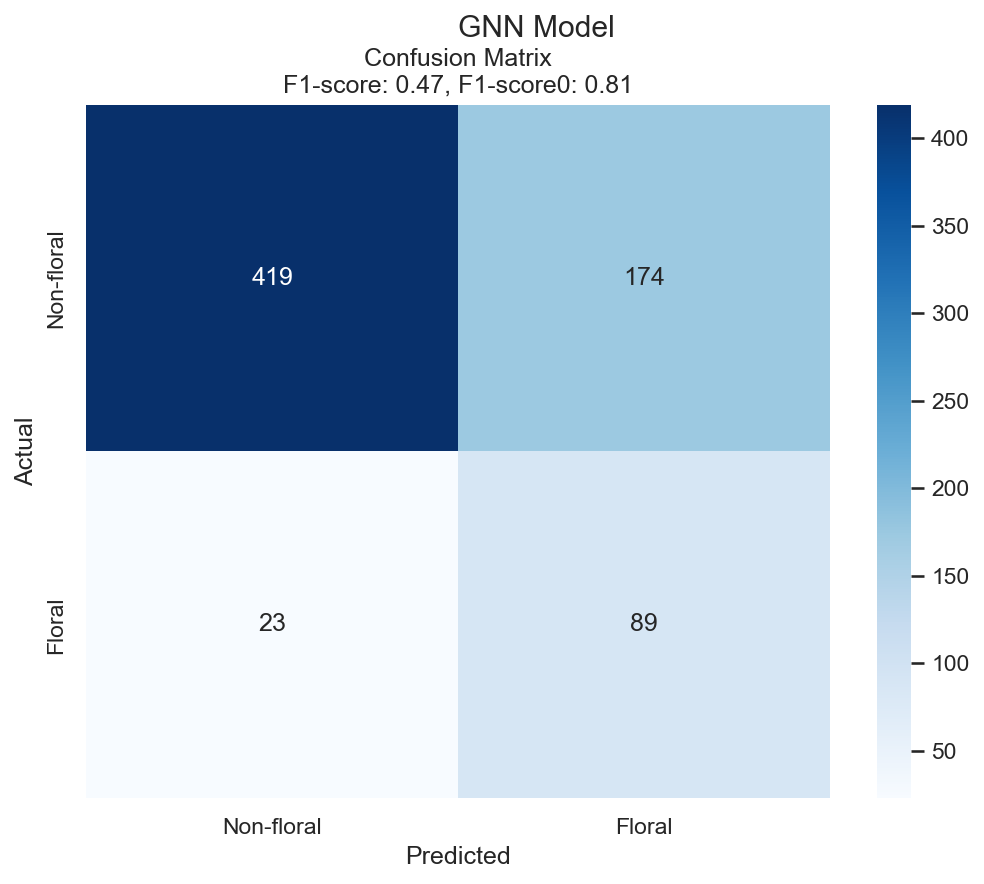

In [37]:
# Evaluate performance
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
gin.validate.evaluate_model(all_labels, all_preds > 0.5)
gin.validate.plot_confusion_matrix(all_labels, all_preds > 0.5, suptitle='GNN Model')

In [39]:
from gin.extra.validate import evaluate_thresholds_gnn
thresholds = np.arange(0.0,1.0,0.01)
results = evaluate_thresholds_gnn(model, test_data, thresholds)
results

/Users/ryoung/Code/repos/SMELL/DREAM/env/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/ryoung/Code/repos/SMELL/DREAM/gin/extra/validate.py:37: RuntimeWarning: invalid value encountered in scalar divide
  prec0 = np.sum((y_pred == 0) & (all_labels == 0)) / np.sum(y_pred == 0)
/Users/ryoung/Code/repos/SMELL/DREAM/gin/extra/validate.py:39: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * (precision * recall) / (precision + recall)
/Users/ryoung/Code/repos/SMELL/DREAM/gin/extra/validate.py:35: RuntimeWarning: invalid value encountered in scalar divide
  precision = np.sum((y_pred == 1) & (all_labels == 1)) / np.sum(y_pred == 1)
/Users/ryoung/Code/repos/SMELL/DREAM/gin/extra/validate.py:35: RuntimeWarning: invalid value encountered in scalar divide
  precision = np.sum((y_pred == 1) & (all_labels == 1)) / np.sum(y_pred == 1)
/Users/ryoung/Cod

,Threshold,Accuracy,Precision,Recall,F1,F1_0,Pr_auc,Roc_auc
0,0.00,0.158865,0.158865,1.000000,0.274174,NaN,0.579433,0.500000
1,0.01,0.286525,0.178982,0.973214,0.302358,0.269956,0.578226,0.565022
2,0.02,0.329078,0.188256,0.973214,0.315485,0.342142,0.582863,0.590317
3,0.03,0.360284,0.195691,0.973214,0.325859,0.391363,0.586580,0.608867
4,0.04,0.395745,0.204887,0.973214,0.338509,0.443864,0.591178,0.629946
...,...,...,...,...,...,...,...,...
95,0.95,0.841135,NaN,0.000000,NaN,0.913713,0.579433,0.500000
96,0.96,0.841135,NaN,0.000000,NaN,0.913713,0.579433,0.500000
97,0.97,0.841135,NaN,0.000000,NaN,0.913713,0.579433,0.500000
98,0.98,0.841135,NaN,0.000000,NaN,0.913713,0.579433,0.500000


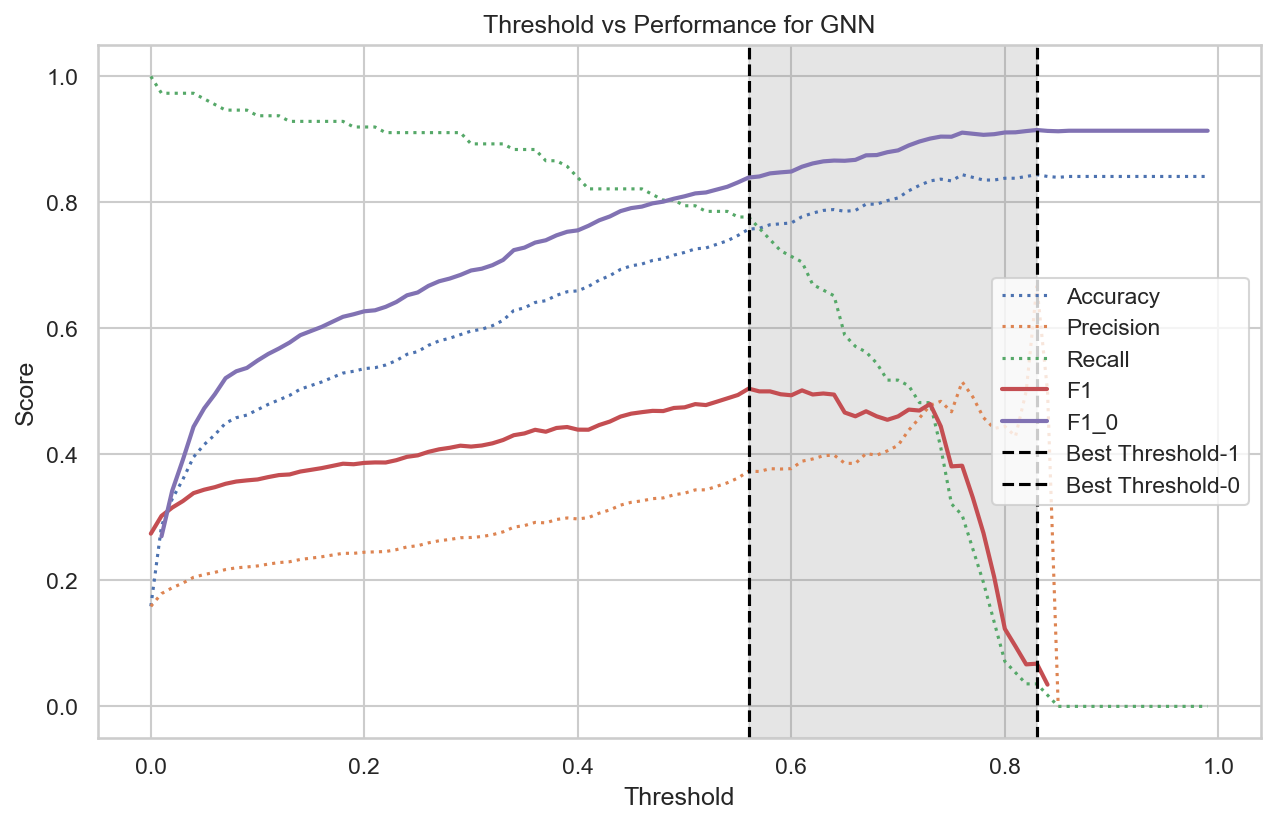

In [40]:
gin.validate.plot_threshold_results(results, model_name="GNN")

## Conclusions

The `MLP` achieves a very similar performance to the simpler method above.

Notably, the resampled model for the `MLP` does **not** perform any better, unlike the `RandomForest` above. In practice, we could try other methods of rebalancing and data augmentation techniques given sparse samples.

The GNN model, while an interesting exercise, does not perform as well as the simpler models. This is typical for neural networks with smaller datasets.

<h4> Better yet -- pull a model from HuggingFace 🤗  that has been pre-trained on other molecules to leverage the knowledge seen in other data.</h4>

# The End